Documentação da Análise Exploratória da base de dados de propriedades do Oleo 
Extraído de dados Publicos (artigos e bancos de dados)

## Imports

In [1]:
# Importação de bibliotecas 
from platform import python_version

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import graphviz

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score,max_error, mean_absolute_error, mean_squared_error
import statistics as st 

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

#TRANFORMA KERA MODEL EM SCIKIT LEARN MODEL (Implementation of the scikit-learn classifier API for Keras)
from keras.wrappers.scikit_learn import KerasRegressor

In [2]:
print(f'Python Version {python_version()}')
print(f'Pandas Version {pd.__version__}')
print(f'Tensor Flow Version {tf.__version__}')

Python Version 3.8.8
Pandas Version 1.2.4
Tensor Flow Version 2.7.0


## Functions

In [3]:
def statistcs(y_test, Resultado):
    
    Resultados_Estatisticos = []
    
    MAE = round(mean_absolute_error(y_test, Resultado),2)
    MAPE_var = round(MAPE(y_test, Resultado)*100,2)
    RMSE = round(mean_squared_error(y_test, Resultado)**0.5,2)
    MAX_ERROR = round(max_error(y_test, Resultado),2)
    R2_test = round(r2_score(y_test, Resultado),4)
    
    y_test = np.array(y_test, dtype='f')
    prediction_error = abs(y_test.flatten() - Resultado.flatten())
    
    Stdev_abs = round(st.stdev(prediction_error),2)
    Stdev_rel = round(st.stdev(prediction_error/st.mean(prediction_error)),2) 
    
    Resultados_Estatisticos.append([MAE, MAPE_var, RMSE, Stdev_abs, Stdev_rel, MAX_ERROR, R2_test])
    
    Error_matrix = pd.DataFrame(data = Resultados_Estatisticos, columns = ['MAE','MAPE_(%)','RMSE','SDa', 'SDr','Emax','R2'])
    
    return Error_matrix

## Dataset Creation

In [4]:
# Criação de DATASET 
df = pd.read_csv('PB-DATASET-API.csv', sep =',', decimal = '.' )


df['OilGrav'] = round((141.5/(df['API']+131.5)),3)
display(df)

properties = df.columns
print(properties)

PB    RS     GG   API  TEMP  OilGrav
0    4509  1409  0.799  42.5   260    0.813
1    3516   950  0.980  31.7   230    0.867
2    3811   909  0.732  38.0   180    0.835
3    4750  1280  0.756  38.6   180    0.832
4    4026  1052  0.767  37.4   193    0.838
..    ...   ...    ...   ...   ...      ...
722  2692   393  0.631  38.6   179    0.832
723  3420  1212  0.685  42.3   194    0.814
724  3160  1213  0.705  45.4   186    0.800
725  3063   586  0.628  32.2   180    0.864
726  3851   819  0.663  34.1   243    0.854

[727 rows x 6 columns]

Index(['PB', 'RS', 'GG', 'API', 'TEMP', 'OilGrav'], dtype='object')


In [5]:
#verificação se há dados faltantes
#e obter informações dos dados presentes

print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727 entries, 0 to 726
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PB       727 non-null    int64  
 1   RS       727 non-null    int64  
 2   GG       727 non-null    float64
 3   API      727 non-null    float64
 4   TEMP     727 non-null    int64  
 5   OilGrav  727 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 34.2 KB
None


PB           RS          GG         API        TEMP  \
count   727.000000   727.000000  727.000000  727.000000  727.000000   
mean   2003.755158   633.861073    1.137160   34.927235  196.405777   
std    1441.172613   506.565126    0.434983    8.500812   53.221577   
min      79.000000     9.000000    0.521000    6.000000   74.000000   
25%     815.000000   267.000000    0.815000   30.800000  160.000000   
50%    1755.000000   514.000000    1.000000   37.400000  194.000000   
75%    2900.500000   833.500000    1.316500   40.000000  238.000000   
max    7142.000000  3299.000000    3.445000   56.800000  342.000000   

          OilGrav  
count  727.000000  
mean     0.852585  
std      0.046343  
min      0.751000  
25%      0.825000  
50%      0.838000  
75%      0.872000  
max      1.029000

In [6]:
minmax = []
for coluna in df.columns:
    minmax.append([df[coluna].min(), df[coluna].max()])

df_norm = (df-df.min())/(df.max()-df.min())
display(df_norm)

dfminmax = pd.DataFrame(minmax, columns = ['Min', 'Max'], index = ['PB','RS','GG','API','Temp','OilGrav'])
dfminmax = dfminmax.T
display (dfminmax)

PB        RS        GG       API      TEMP   OilGrav
0    0.627212  0.425532  0.095075  0.718504  0.694030  0.223022
1    0.486620  0.286018  0.156977  0.505906  0.582090  0.417266
2    0.528387  0.273556  0.072161  0.629921  0.395522  0.302158
3    0.661334  0.386322  0.080369  0.641732  0.395522  0.291367
4    0.558828  0.317021  0.084131  0.618110  0.444030  0.312950
..        ...       ...       ...       ...       ...       ...
722  0.369956  0.116717  0.037620  0.641732  0.391791  0.291367
723  0.473028  0.365653  0.056088  0.714567  0.447761  0.226619
724  0.436217  0.365957  0.062927  0.775591  0.417910  0.176259
725  0.422483  0.175380  0.036594  0.515748  0.395522  0.406475
726  0.534051  0.246201  0.048564  0.553150  0.630597  0.370504

[727 rows x 6 columns]

PB      RS     GG   API   Temp  OilGrav
Min    79.0     9.0  0.521   6.0   74.0    0.751
Max  7142.0  3299.0  3.445  56.8  342.0    1.029

### Empirical Correlations

In [7]:
#df2 = pd.DataFrame()

df['Standing'] = round(18.2*(((df['RS']/df['GG'])**0.83)*10**((0.00091*df['TEMP'])-0.0125*df['API'])-1.4),2)

g = pd.DataFrame(df).to_numpy()
VasquezBeggs = []
glaso = []
gamags = []
A = []
x = []
PetroskiFarshad = []

for item in range(len(g)):
  if g[item][3] > 30:
    c1, c2, c3 = 56.18, 0.84246, -10.393
  else:
    c1, c2, c3 = 27.624, 0.914328, -11.172
  
  gamags.append(g[item][2]*(1+0.00005912*g[item][3]*60*math.log(164.7/114.7,10)))
  VasquezBeggs.append(round((c1*(g[item][1]/gamags[item])*10**(c3*(g[item][3]/(g[item][4]+460))))**c2,2))

  A.append(math.log(((g[item][1]/g[item][2])**0.816)*g[item][4]**0.173/g[item][3]**0.989,10))
  glaso.append(round(10**(1.7669+1.7447*A[item]-0.30218*(A[item]**2)),2))

df['Vasquez-Beggs'] = VasquezBeggs
df['Glaso'] = glaso
df['Al-Marhoun'] = round(0.00538088*(df['RS']**0.715082)*(df['GG']**(-1.87784))*(df['OilGrav']**3.1437)*((df['TEMP']+460)**1.32657),2)
df['Petroski-Farshad'] = round(112.727*(df['RS']**0.577421)/((df['GG']**0.8439)*10**(0.0007916*df['API']**1.541-0.000045618*(df['TEMP']**1.3911)))-1391.051,2)


display(df)


PB    RS     GG   API  TEMP  OilGrav  Standing  Vasquez-Beggs    Glaso  \
0    4509  1409  0.799  42.5   260    0.813   4544.39        4824.92  4643.88   
1    3516   950  0.980  31.7   230    0.867   3538.33        3813.25  3816.93   
2    3811   909  0.732  38.0   180    0.835   3262.55        3572.98  3748.39   
3    4750  1280  0.756  38.6   180    0.832   4154.58        4551.22  4637.32   
4    4026  1052  0.767  37.4   193    0.838   3707.83        4054.27  4140.29   
..    ...   ...    ...   ...   ...      ...       ...            ...      ...   
722  2692   393  0.631  38.6   179    0.832   1793.31        1956.14  2095.59   
723  3420  1212  0.685  42.3   194    0.814   3988.22        4317.88  4472.26   
724  3160  1213  0.705  45.4   186    0.800   3501.79        3761.80  4091.66   
725  3063   586  0.628  32.2   180    0.864   3039.45        3380.48  3512.53   
726  3851   819  0.663  34.1   243    0.854   4153.99        4436.60  4313.13   

     Al-Marhoun  Petroski-Farshad  
0       4713.98           4934.83  
1       2803.68           3667.77  
2       3778.29           3881.62  
3       4491.23           4785.97  
4       3990.80           4273.19  
..          ...               ...  
722     2704.92           2243.28  
723     4994.00           4728.26  
724     4410.19           4144.63  
725     4097.69           3815.93  
726     5134.15           4884.89  

[727 rows x 11 columns]

Empty DataFrame
Columns: [MAE, MAPE_(%), RMSE, SDa, SDr, Emax, R2]
Index: []

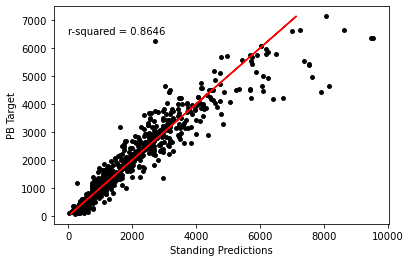

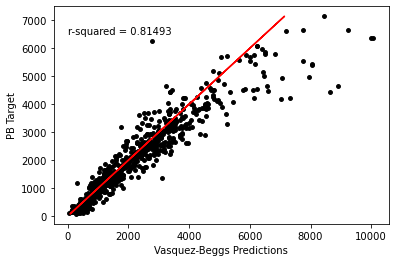

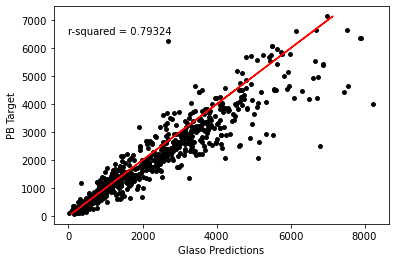

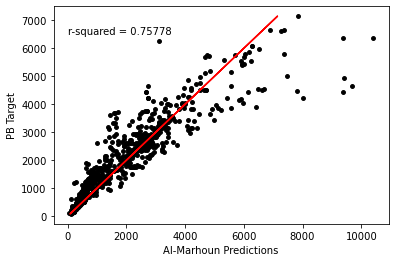

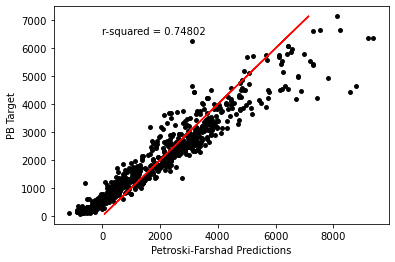

In [8]:
correlations = ['Standing', 'Vasquez-Beggs', 'Glaso', 'Al-Marhoun','Petroski-Farshad']

Error_Results = pd.DataFrame(columns = ['MAE','MAPE_(%)','RMSE','SDa', 'SDr','Emax','R2'])
display(Error_Results)

for coluna in correlations:
    plt.scatter(df[coluna], df['PB'], color = 'k', marker = 'o', s = 15)
    plt.xlabel(coluna + ' Predictions')
    plt.ylabel('PB Target')
    plt.plot(df['PB'], df['PB'], color = 'r')
    r2 = round(r2_score(df['PB'],df[coluna]),5)
    plt.annotate(f'r-squared = {r2}', (0,6500))
    plt.show()

## Data Vizualization

In [9]:
#!pip install  plotly

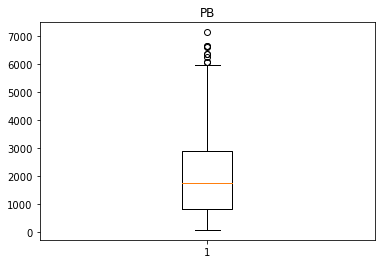

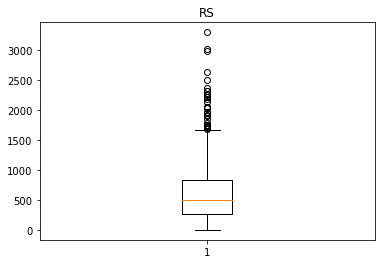

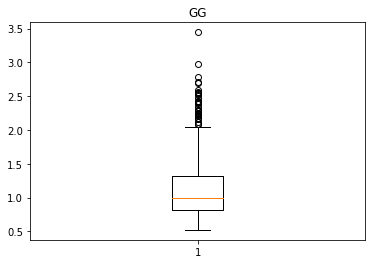

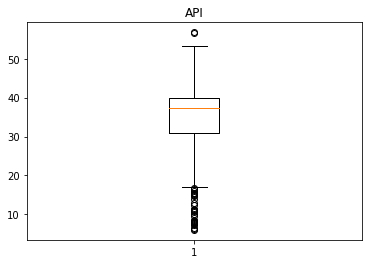

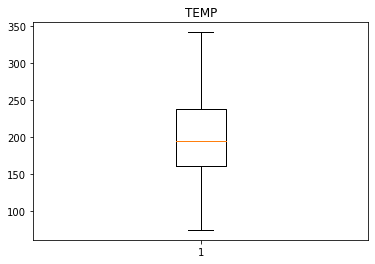

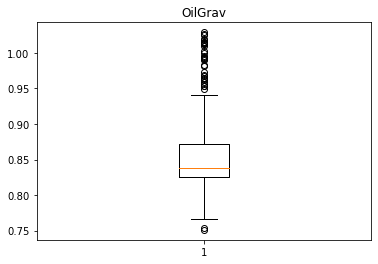

In [10]:
for coluna in properties:
    plt.boxplot(df[coluna])
    plt.title(coluna)
    plt.show()

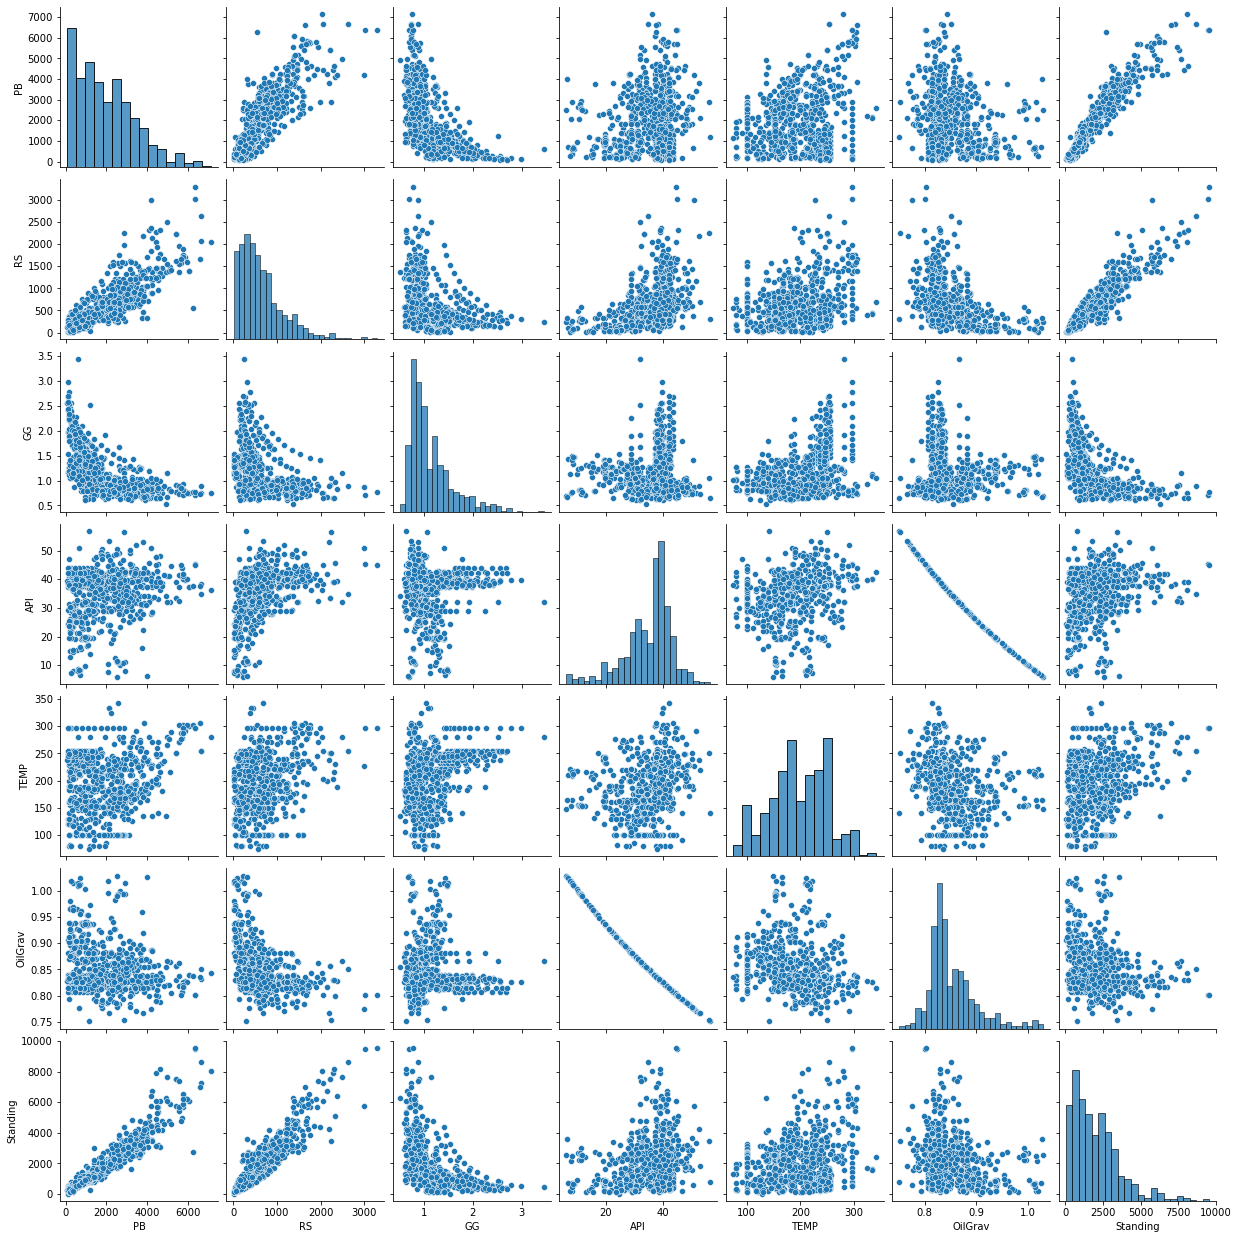

In [11]:
#!pip install seaborn

sns.pairplot(df.iloc[:,0:7], palette="GnBu_d")

<AxesSubplot:>

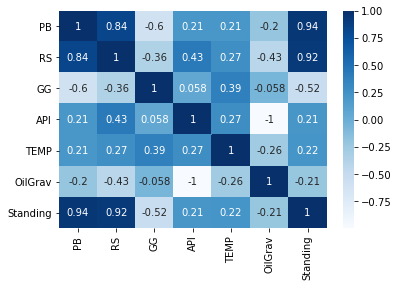

In [12]:
sns.heatmap(df.iloc[:,0:7].corr(), annot=True, cmap="Blues") #annot mostra os coeficientes da matriz

Podemos verificar a grande correlação da Razão de Gás Óleo (RS) com a Pressão de Bolha
Isto porque o RS também é um propriedade determinável pela Temperatura, dendidade específica do gás e do óleo, ou seja, RS = f(T, P, GasGrav, OilGrav).

O ideal seria criação de modelos preditivos de para todas as propriedades termodinâmicas e físico químicas e compará-las com as
correlações empíricas Standing, Vasquez-Beggs, Al-Marhoun, Petrosky-Farshad e etc...
No entando os procedimentos seriam semelhantes. 

Apesas da possibildiade de enfatizar a melhoria na preção por modelos criados por machine learning, este não será realizado.

No trabalho de conclusão de curso intitulado 

"MODELAGEM DE PROPRIEDADES FÍSICO QUÍMICAS E TERMODINÂMICAS DO ÓLEO E GÁS UTILIZANDO INTELIGÊNCIA ARTIFICIAL"

abordei a predição utilizando algumas ténicas presentes no ramo de machine learning para predição de Pb e Bo
e ainda comparei os resultados obtidos com os Softwares Python (Open Source) e Statistica®, produzido pela Tibco utilizando licença estudante e versão trial

#Dataset Split Test

In [13]:
#X = df.iloc[:, 1:5].values
#y = df.iloc[:, 0].values

#correlations_values = df2.values

X = df.drop('PB',axis='columns')
y = df.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

X_train_data, X_test_data, Correlations_pred = X_train.iloc[:,0:5], X_test.iloc[:,0:5], X_train.iloc[:,5::] 

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)


#Motivation

Nas figura acima são demostradas o grau de dispersão dos valores predito pelas correlações empíricas em relação
aos valores verdadeiros de pressão de bolha determinados por métodos experimentais

Observa-se que as correlações apresentam grandes dispersões na determinição de valores altos de Pressão de Bolha, evidenciando as limitações das correlações empíricas hoje amplamente utilizadas. 

Por este e por outros motivos, a utilização do aprendizado de máquina (AM) surge como alternativa para geração de modelos que melhor se adaptam aos dados que se possuem. Nos modelos gerados por AM são métricas de eficiência do poder de predição e quanto ao poder de generalização. 

Modelos superajustados (overffiting) e sobreajustados (underfitting) não são desejáveis, com isso são variados parâmetros com o objetivo de se obter um modelo genalizado capaz de prover saídas confiáveis à dados não utilizados no treinamento do mesmo.



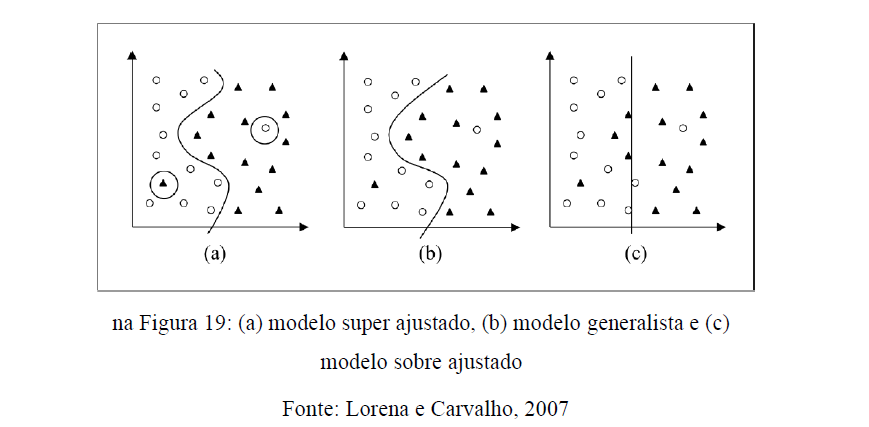

A proposta do trabalho foi gerar diferentes modelos de predição utilizando o aprendizado de máquinas, selecionando os hiperparâmetros que possibilitam a obtenção de valores da propriedade em questão com menor erro associado. 

Para quantificação dos resultados foi utilizada uma espécies de raqnueamento por Ikiensikimama e Azubuike, 2012, no qual é realizado um somatório da multiplicação dos pesos atribuídos a diferentes avaliadores estatíticos com as respectivas méticas de erros medidas, como é mostrado abaixo:




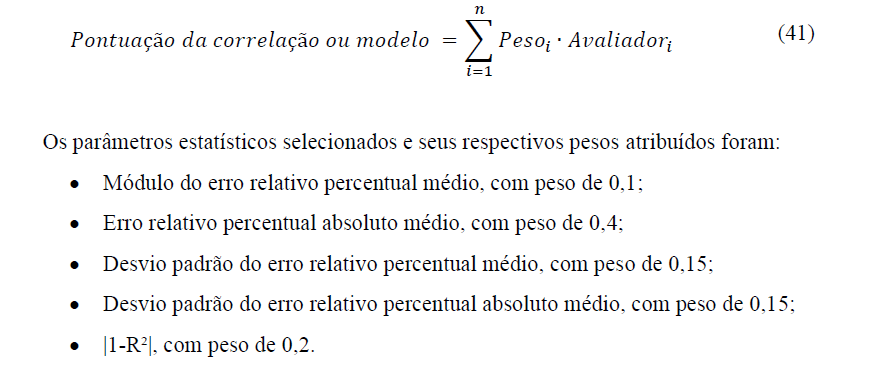


### Correlations 

In [14]:
for coluna in correlations:
    Error_Results = pd.concat([Error_Results, statistcs(y_test, np.array(X_test[coluna]))])
    
Error_Results.index = correlations

display(Error_Results)

MAE  MAPE_(%)    RMSE     SDa   SDr     Emax      R2
Standing          320.36     24.31  566.04  467.63  1.46  3549.07  0.8511
Vasquez-Beggs     373.12     28.19  655.57  540.16  1.45  4230.90  0.8002
Glaso             405.17     25.72  608.28  454.64  1.12  3580.01  0.8280
Al-Marhoun        426.71     21.68  734.84  599.50  1.40  4943.84  0.7490
Petroski-Farshad  559.36     78.19  734.31  476.73  0.85  4151.92  0.7494

### Árvores de Decisão

In [15]:
dt = DecisionTreeRegressor()

display(dt.get_params())

max_depth = list(np.arange(2,21,2))

min_samples_leaf = list(np.arange(2,15,2))

min_samples_split = list(np.arange(2,30,2))
      
# Defining params_dt   
params_dt = {'max_depth': max_depth, 'min_samples_leaf':min_samples_leaf,'min_samples_split': min_samples_split}

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [16]:
# Instantiate grid_dt
grid_dt = GridSearchCV(estimator=dt,
                       param_grid=params_dt,
                       scoring='r2',
                       cv=10,
                       n_jobs=-1)

#or scoring='roc_auc'

grid_dt.fit(X_train_data, y_train)

best_model = grid_dt.best_estimator_

print(f'Best Paramns: {grid_dt.best_params_}')

Best Paramns: {'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 2}


In [17]:
Treinamento = best_model.predict(X_train_data)
Resultado = best_model.predict(X_test_data)

R2_treinamento = round(r2_score(y_train, Treinamento),4)
R2_test = round(r2_score(y_test, Resultado),4)

print(f' R2_Train = {R2_treinamento}')
print(f' R2_test = {R2_test}')    

Error_Results = pd.concat([Error_Results, statistcs(y_test, Resultado)])

display(Error_Results)

 R2_Train = 0.9008
 R2_test = 0.8455


MAE  MAPE_(%)    RMSE     SDa   SDr     Emax      R2
Standing          320.36     24.31  566.04  467.63  1.46  3549.07  0.8511
Vasquez-Beggs     373.12     28.19  655.57  540.16  1.45  4230.90  0.8002
Glaso             405.17     25.72  608.28  454.64  1.12  3580.01  0.8280
Al-Marhoun        426.71     21.68  734.84  599.50  1.40  4943.84  0.7490
Petroski-Farshad  559.36     78.19  734.31  476.73  0.85  4151.92  0.7494
0                 367.46     27.87  576.54  445.19  1.21  4130.56  0.8455

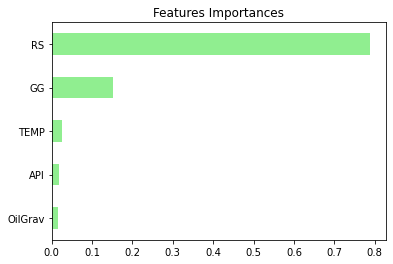

In [18]:
# A pd.Series of features importances
importances = pd.Series(data=best_model.feature_importances_,
                        index= X_train_data.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

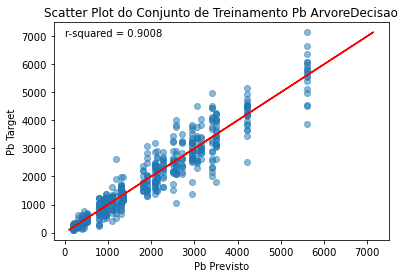

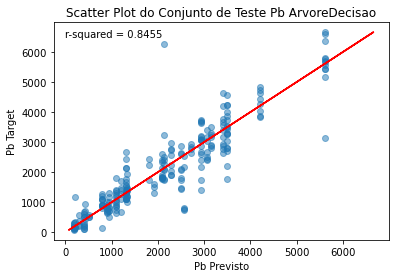

In [19]:
plt.scatter(Treinamento, y_train, alpha=0.5)
plt.plot(y_train, y_train, color = 'red')
plt.title('Scatter Plot do Conjunto de Treinamento Pb ArvoreDecisao')
plt.ylabel('Pb Target')
plt.xlabel('Pb Previsto')
plt.annotate(f'r-squared = {R2_treinamento}', (0,7000))
plt.show()

plt.scatter(Resultado, y_test, alpha=0.5)
plt.plot(y_test,y_test, color = 'red')
plt.title('Scatter Plot do Conjunto de Teste Pb ArvoreDecisao')
plt.ylabel('Pb Target')
plt.xlabel('Pb Previsto')
plt.annotate(f'r-squared = {R2_test}', (0,6500))
plt.show()

#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)

#tree.plot_tree(best_model,
               feature_names = ['RS','GG','API','Temp', 'Oil Grav'],
               filled = True);


#fig.savefig('DT_BEST_MODEL.png')

tree.export_graphviz(best_model,
                     out_file="tree.dot",
                     feature_names = ['RS','GG','API','Temp', 'Oil Grav'], 
                     leaves_parallel=False,
                     filled = True)

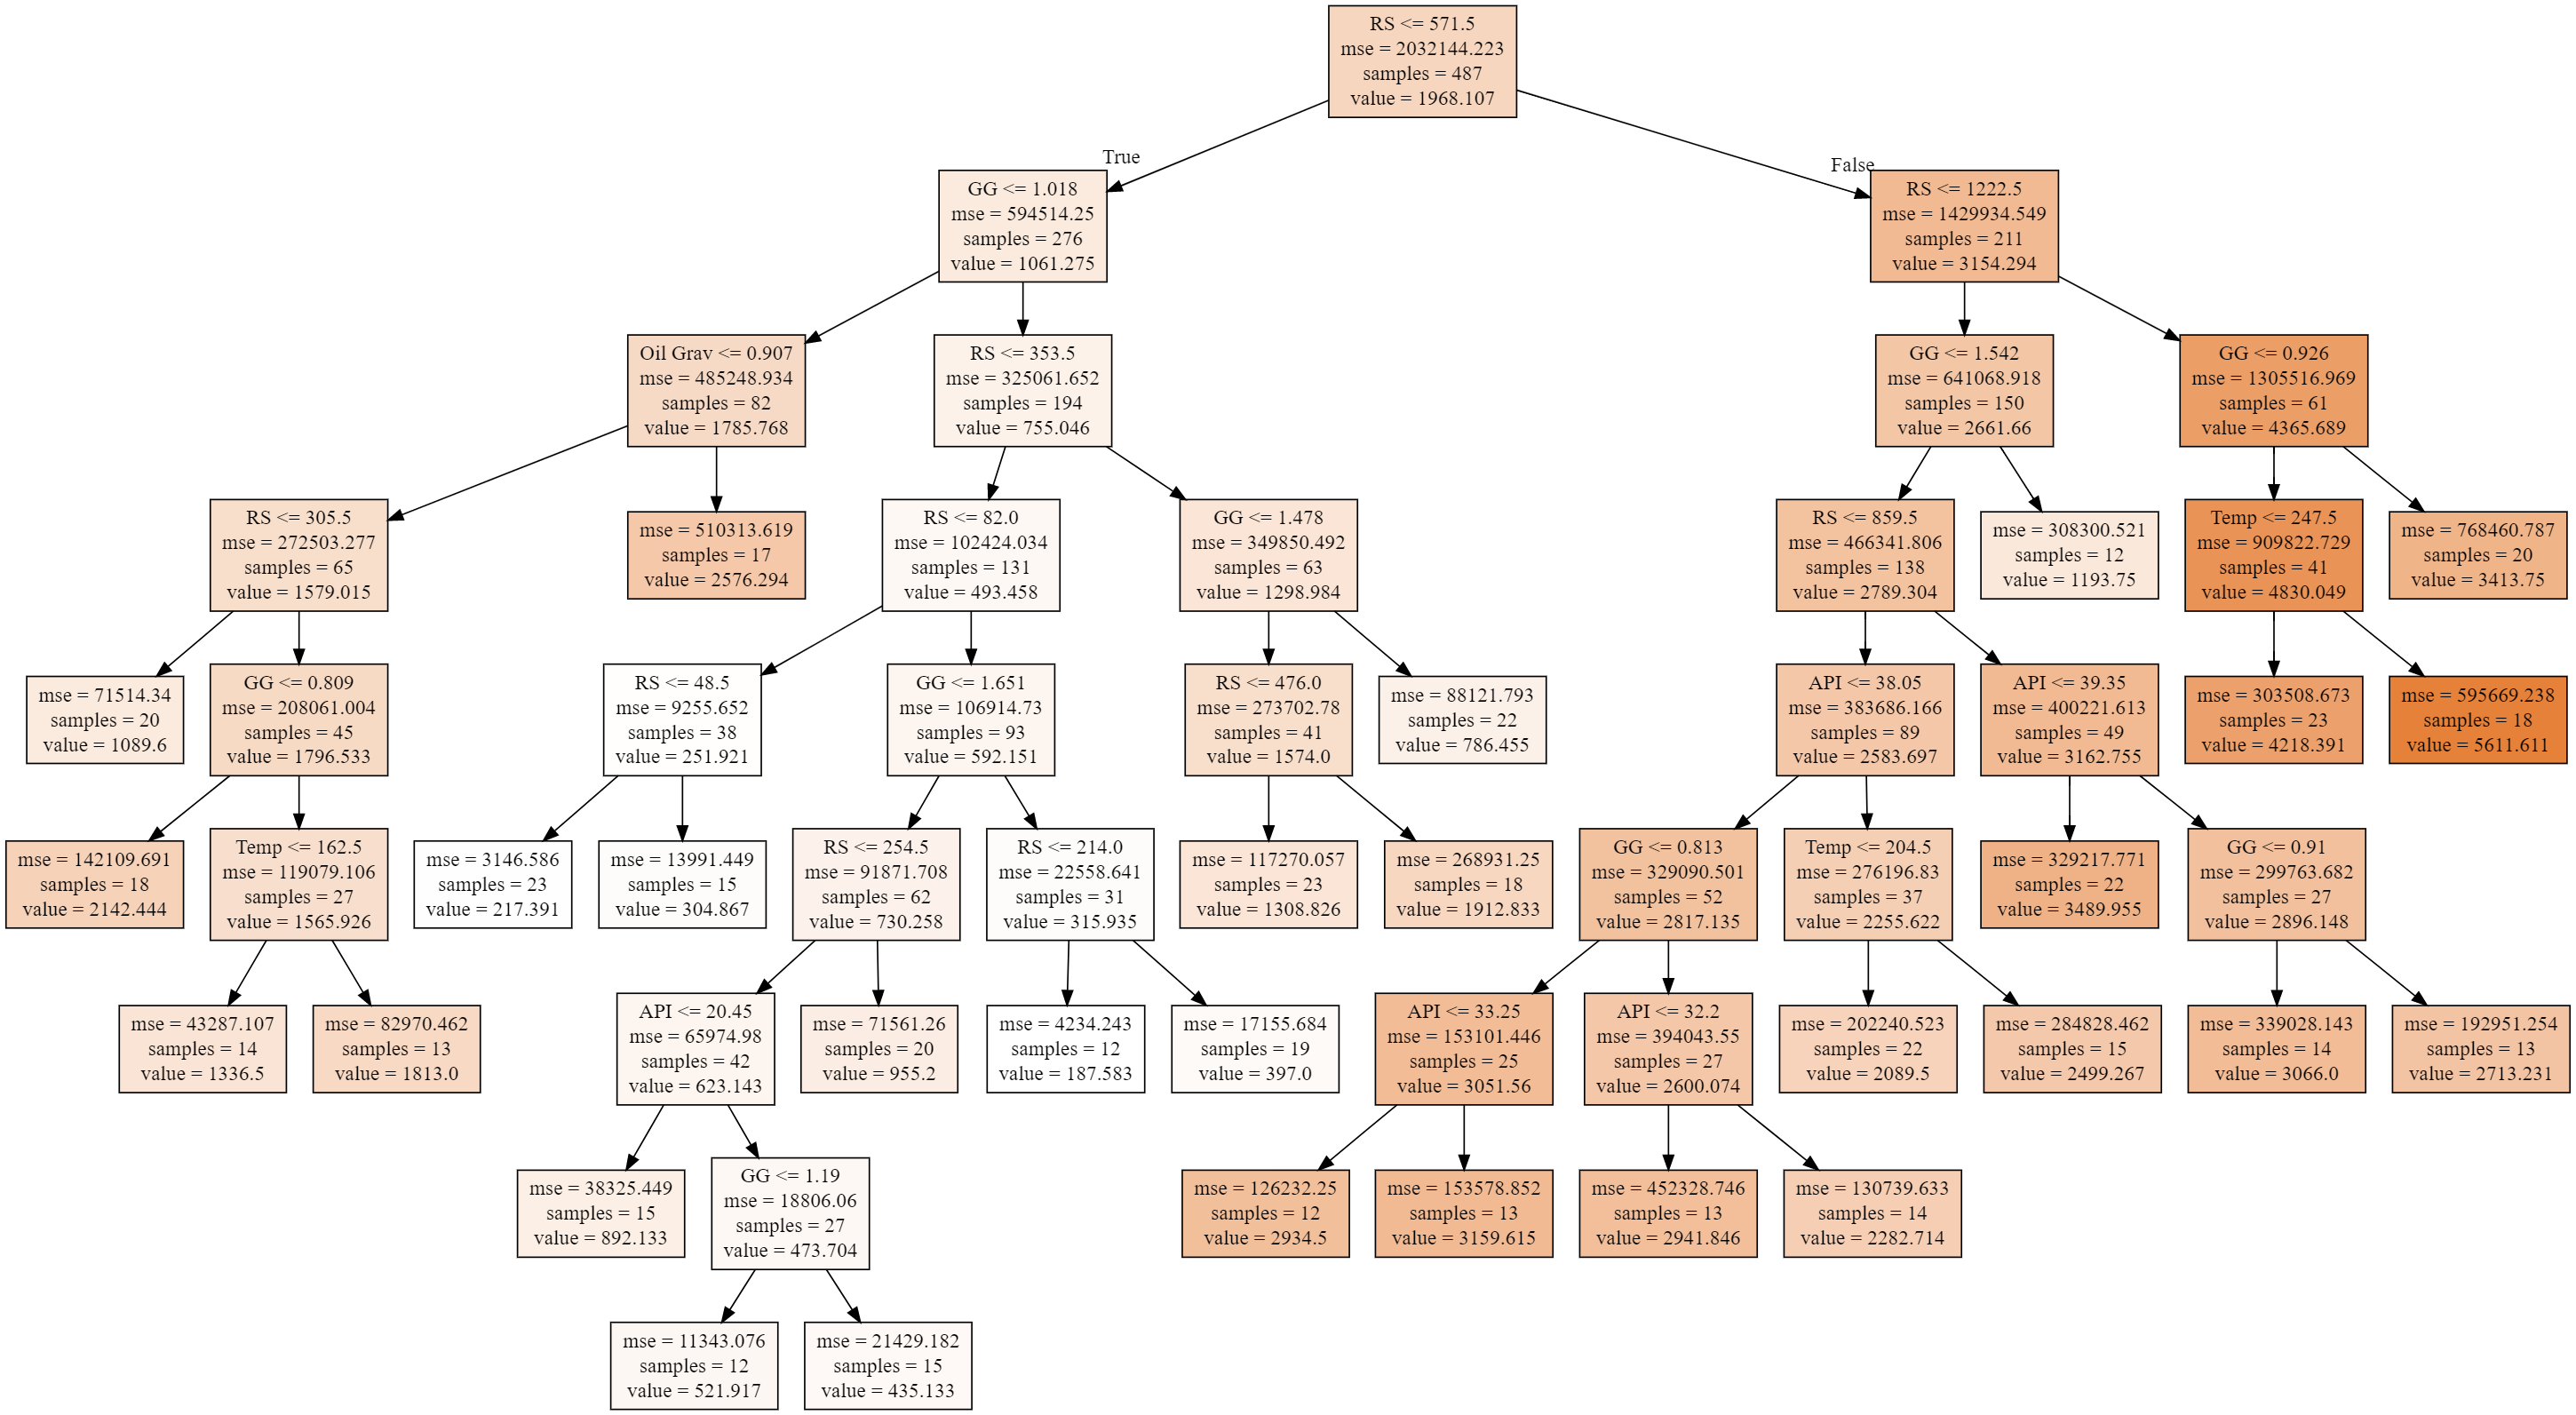

### Random Forest

In [20]:
rf = RandomForestRegressor()

display(rf.get_params())

max_depth = list(np.arange(2,21,2))
n_estimators =  list(np.arange(2,30,2))
min_samples_leaf = list(np.arange(2,15,2))

      
# Defining params_dt   
params_rf = {'max_depth': max_depth, 'min_samples_leaf':min_samples_leaf,'n_estimators': n_estimators}
#'max_features': ['log2', 'auto', 'sqrt']

# Instantiate grid_dt
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='r2',
                       cv=10,
                       n_jobs=-1)

#or scoring='roc_auc'

grid_rf.fit(X_train_data, y_train)

best_model = grid_rf.best_estimator_

print(f'Best Paramns: {grid_rf.best_params_}')

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Best Paramns: {'max_depth': 12, 'min_samples_leaf': 2, 'n_estimators': 20}


C:\Users\danie\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [21]:
Treinamento = best_model.predict(X_train_data)
Resultado = best_model.predict(X_test_data)

R2_treinamento = round(r2_score(y_train, Treinamento),4)
R2_test = round(r2_score(y_test, Resultado),4)

print(f' R2_Train = {R2_treinamento}')
print(f' R2_test = {R2_test}')    

Error_Results = pd.concat([Error_Results, statistcs(y_test, Resultado)])

display(Error_Results)

 R2_Train = 0.9786
 R2_test = 0.9107


MAE  MAPE_(%)    RMSE     SDa   SDr     Emax      R2
Standing          320.36     24.31  566.04  467.63  1.46  3549.07  0.8511
Vasquez-Beggs     373.12     28.19  655.57  540.16  1.45  4230.90  0.8002
Glaso             405.17     25.72  608.28  454.64  1.12  3580.01  0.8280
Al-Marhoun        426.71     21.68  734.84  599.50  1.40  4943.84  0.7490
Petroski-Farshad  559.36     78.19  734.31  476.73  0.85  4151.92  0.7494
0                 367.46     27.87  576.54  445.19  1.21  4130.56  0.8455
0                 259.42     16.90  438.27  353.99  1.36  3868.68  0.9107

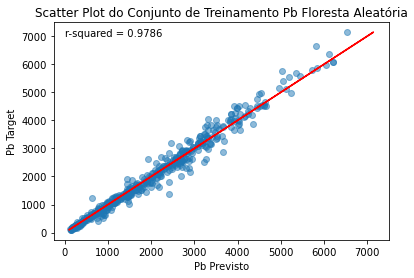

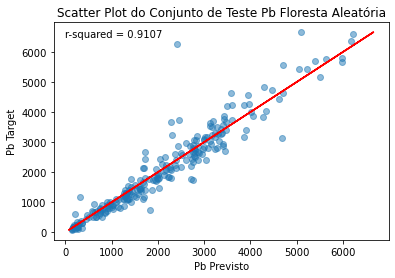

In [22]:
plt.scatter(Treinamento, y_train, alpha=0.5)
plt.plot(y_train, y_train, color = 'red')
plt.title('Scatter Plot do Conjunto de Treinamento Pb Floresta Aleatória')
plt.ylabel('Pb Target')
plt.xlabel('Pb Previsto')
plt.annotate(f'r-squared = {R2_treinamento}', (0,7000))
plt.show()

plt.scatter(Resultado, y_test, alpha=0.5)
plt.plot(y_test,y_test, color = 'red')
plt.title('Scatter Plot do Conjunto de Teste Pb Floresta Aleatória')
plt.ylabel('Pb Target')
plt.xlabel('Pb Previsto')
plt.annotate(f'r-squared = {R2_test}', (0,6500))
plt.show()

## SVR

### Tunning By GRID SEARCH

In [23]:
C = [0.001, 0.01, 0.1, 1.0, 10]
gamma = [0.01,0.317,10.0, 317, 10000]
epsilon =[0.01, 0.0317, 0.1, 0.317, 1.0]

svr = SVR()

display(svr.get_params())

# Defining params_dt   
params_svr = {'C': C, 'gamma':gamma,'epsilon': epsilon}
#'max_features': ['log2', 'auto', 'sqrt']

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [24]:
df_norm = minmax_scale(df)
X_norm = pd.DataFrame(df_norm[:,1:7], columns = properties )
X_norm = X_norm.drop('PB', axis = 1)
y_norm = df_norm[:,0]

X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y_norm, test_size=0.33, random_state=0)

X_train_data_norm, X_test_data_norm = X_train_norm.iloc[:,0:5], X_test_norm.iloc[:,0:5]

In [25]:
grid_SVR = GridSearchCV(estimator=svr,
                       param_grid=params_svr,
                       scoring='r2',
                       cv=10,
                       n_jobs=-1)

grid_SVR.fit(X_train_data_norm, y_train_norm)

best_model_svr = grid_SVR.best_estimator_

print(f'Best Paramns: {grid_SVR.best_params_}')

Best Paramns: {'C': 1.0, 'epsilon': 0.01, 'gamma': 10.0}


In [26]:
#Desnomalization 
dfminmax

min_PB = 79
max_PB = 7142

Treinamento = best_model_svr.predict(X_train_data_norm)
Resultado = best_model_svr.predict(X_test_data_norm)

Treinamento = Treinamento * (max_PB - min_PB) + min_PB
Resultado = Resultado * (max_PB - min_PB) + min_PB

In [27]:
print(type(Resultado),type(Treinamento))

print(Resultado.shape,Treinamento.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(240,) (487,)


 R2_Train = 0.9682
 R2_test = 0.9507


MAE  MAPE_(%)    RMSE     SDa   SDr     Emax      R2
Standing          320.36     24.31  566.04  467.63  1.46  3549.07  0.8511
Vasquez-Beggs     373.12     28.19  655.57  540.16  1.45  4230.90  0.8002
Glaso             405.17     25.72  608.28  454.64  1.12  3580.01  0.8280
Al-Marhoun        426.71     21.68  734.84  599.50  1.40  4943.84  0.7490
Petroski-Farshad  559.36     78.19  734.31  476.73  0.85  4151.92  0.7494
0                 367.46     27.87  576.54  445.19  1.21  4130.56  0.8455
0                 259.42     16.90  438.27  353.99  1.36  3868.68  0.9107
0                 178.35     13.07  325.82  273.24  1.53  2727.40  0.9507

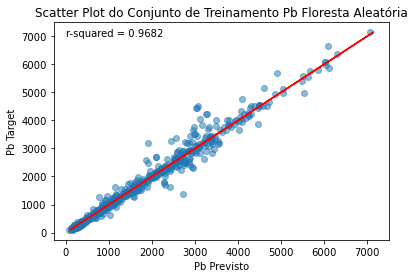

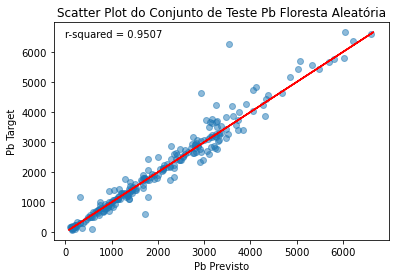

In [28]:
R2_treinamento = round(r2_score(y_train, Treinamento),4)
R2_test = round(r2_score(y_test, Resultado),4)

print(f' R2_Train = {R2_treinamento}')
print(f' R2_test = {R2_test}')    

Error_Results = pd.concat([Error_Results, statistcs(y_test, Resultado)])

display(Error_Results)

plt.scatter(Treinamento, y_train, alpha=0.5)
plt.plot(y_train, y_train, color = 'red')
plt.title('Scatter Plot do Conjunto de Treinamento Pb Floresta Aleatória')
plt.ylabel('Pb Target')
plt.xlabel('Pb Previsto')
plt.annotate(f'r-squared = {R2_treinamento}', (0,7000))
plt.show()

plt.scatter(Resultado, y_test, alpha=0.5)
plt.plot(y_test,y_test, color = 'red')
plt.title('Scatter Plot do Conjunto de Teste Pb Floresta Aleatória')
plt.ylabel('Pb Target')
plt.xlabel('Pb Previsto')
plt.annotate(f'r-squared = {R2_test}', (0,6500))
plt.show()

# ANN

*FURTUNA, R., CURTEANU, S. e CAZACU, M., Optimization methodology applied to feed-forward artificial neural network parameters. International Journal of Quantum Chemistry, v. 111, n. 3, p. 539–553, Iasi, Romênia, dezembro, 2009*

This Article reports the optimization methodology, this means, how to tune hyperparameters of our neral Network. 

To optimize network performance, a series of neural network parameters such as **number of hidden layers, number of neurons in
the hidden layers, learning rate, momentum term, and activation function of the output layer** were elected after series of simulations in which there were varied all these parameters, while choosing a optimum **number of training epochs**.

The role of the hidden layers is to **detect relationships between network inputs and outputs**.

The most important problem is to find the **minimum number of hidden layers** that can create adequately complex decision boundaries, also reducing the computational time needed for training. For many applications, the optimum number of hidden layers has been found to be less than the number of inputs.

The optimum number of training epochs has to be determined through cross-validation, a highly recommended method for stopping network training. The training set is divided in around 80% data for training and the rest are data for cross-validation. 

Training and testing are done in the same time and the training is stopped when the mean squared error for the cross-validation data set starts to rise. This moment is called point of maximum generalization. Depending on the network performance at this time, different configurations can then be tried, decreasing or increasing the number of neurons in the hidden layer(s)

### Neural Network Hyperpramaeters

- Number of Layers | **Used**
- number os Neurons per Layer | **Used [2, 4, 6, 8, ... ,30]**
- Layer Order 
- Layer Activations | **Used ['sigmoid', 'tanh', 'relu']**
- Batch Sizes |** Used 64**
- Learning Rates | **Used 0.1**
- Optimizer | **Used Adam**

In [29]:
Nin = X_train_data_norm.shape[1]
Nout = 1
#Nhidden = 23

R2melhor = 0
report = []

activation_function = ['sigmoid', 'tanh', 'relu']
iteration = 0

for Nhidden in range(1,31,2):
    
    for hidden_activation in activation_function:
        
        for output_activation in activation_function:
            
            iteration += 1
            print(f'########### Iter {iteration} NHidden {Nhidden} ###########')
            print(f'hidden_activation {hidden_activation} output_activation {output_activation}')

            input_ = keras.layers.Input(shape=(Nin,))
            hidden = keras.layers.Dense(Nhidden, activation=hidden_activation)(input_)
            output = keras.layers.Dense(Nout, activation=output_activation)(hidden)

            # instantiate model
            model = keras.models.Model(inputs=[input_],outputs=[output])

            # define optimizer and learning rate
            optimizer = keras.optimizers.SGD(learning_rate = 0.1)

            # compile model to train it
            model.compile(loss="mean_squared_error", optimizer=optimizer)

            #history = model.fit(X_train_norm,y_train_norm, epochs=500, batch_size = 64)
            
            # Define early_stopping_monitor
            early_stopping_monitor = EarlyStopping(patience = 5)

            # Fit the model
            history = model.fit(X_train_data_norm,y_train_norm, 
                    validation_split=0.1,
                    epochs = 200, batch_size = 64,
                    callbacks = [early_stopping_monitor])
            
            results_ANN = model.predict(X_test_data_norm)
            
            results_ANN = results_ANN * (max_PB - min_PB) + min_PB
    
            R2_test = round(r2_score(y_test, results_ANN),5)
        
            report.append([iteration, Nhidden,hidden_activation, output_activation, R2_test])
    
            if R2_test > R2melhor:
                R2melhor = R2_test
                Best_Tunning = [iteration, Nhidden, hidden_activation, output_activation, R2_test]
                display(Best_Tunning)

Report = pd.DataFrame(report, columns =['iteration', 'Neurons_in_Hidden','hidden_activation', 'output_activation', 'R2_test'] )

display(Report)
display(Best_Tunning)

########### Iter 1 NHidden 1 ###########
hidden_activation sigmoid output_activation sigmoid
Epoch 1/200
7/7 [==============================] - 1s 65ms/step - loss: 0.0491 - val_loss: 0.0490
Epoch 2/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0485 - val_loss: 0.0481
Epoch 3/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0480 - val_loss: 0.0474
Epoch 4/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0476 - val_loss: 0.0468
Epoch 5/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0473 - val_loss: 0.0463
Epoch 6/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0470 - val_loss: 0.0458
Epoch 7/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0468 - val_loss: 0.0455
Epoch 8/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0466 - val_loss: 0.0451
Epoch 9/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0464 - val_loss: 0.0448
Epoch 10/200
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 0.0432 - val_loss: 0.0403
Epoch 167/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0432 - val_loss: 0.0403
Epoch 168/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0432 - val_loss: 0.0403
Epoch 169/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0432 - val_loss: 0.0403
Epoch 170/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0432 - val_loss: 0.0403
Epoch 171/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0432 - val_loss: 0.0403
Epoch 172/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0432 - val_loss: 0.0403
Epoch 173/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0431 - val_loss: 0.0403
Epoch 174/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0431 - val_loss: 0.0403
Epoch 175/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0431 - val_loss: 0.0403
Epoch 176/200
7/7 [=====

Epoch 35/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0319 - val_loss: 0.0305
Epoch 36/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0317 - val_loss: 0.0303
Epoch 37/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0315 - val_loss: 0.0301
Epoch 38/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0313 - val_loss: 0.0299
Epoch 39/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0312 - val_loss: 0.0297
Epoch 40/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0310 - val_loss: 0.0295
Epoch 41/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0308 - val_loss: 0.0294
Epoch 42/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0306 - val_loss: 0.0292
Epoch 43/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0304 - val_loss: 0.0290
Epoch 44/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0302 - val_loss: 0.0289
Epoch 45/200
7/7 [==

7/7 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0087


[4, 1, 'tanh', 'sigmoid', 0.78499]

########### Iter 5 NHidden 1 ###########
hidden_activation tanh output_activation tanh
Epoch 1/200
7/7 [==============================] - 0s 26ms/step - loss: 0.3253 - val_loss: 0.0300
Epoch 2/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0322 - val_loss: 0.0275
Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0301 - val_loss: 0.0271
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0291 - val_loss: 0.0259
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0284 - val_loss: 0.0256
Epoch 6/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0275 - val_loss: 0.0245
Epoch 7/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0265 - val_loss: 0.0234
Epoch 8/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0256 - val_loss: 0.0224
Epoch 9/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0248 - val_loss: 0.0218
Epoch 10/200
7/7 [=====================

Epoch 84/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 85/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 86/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 87/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 88/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 89/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 90/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 91/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 92/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 93/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 94/200
7/7 [==

[5, 1, 'tanh', 'tanh', 0.91628]

########### Iter 6 NHidden 1 ###########
hidden_activation tanh output_activation relu
Epoch 1/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0398 - val_loss: 0.0372
Epoch 2/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0393 - val_loss: 0.0376
Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0391 - val_loss: 0.0375
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0392 - val_loss: 0.0375
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0390 - val_loss: 0.0377
Epoch 6/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0390 - val_loss: 0.0366
Epoch 7/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0386 - val_loss: 0.0367
Epoch 8/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0386 - val_loss: 0.0369
Epoch 9/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0382 - val_loss: 0.0365
Epoch 10/200
7/7 [=====================

Epoch 84/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0094 - val_loss: 0.0087
Epoch 85/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0093 - val_loss: 0.0087
Epoch 86/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0092 - val_loss: 0.0085
Epoch 87/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 88/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 89/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0087
Epoch 90/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0078
Epoch 91/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0080
Epoch 92/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0084 - val_loss: 0.0078
Epoch 93/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0083 - val_loss: 0.0080
Epoch 94/200
7/7 [==

7/7 [==============================] - 0s 6ms/step - loss: 0.0373 - val_loss: 0.0356
Epoch 98/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0373 - val_loss: 0.0355
Epoch 99/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0372 - val_loss: 0.0355
Epoch 100/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0371 - val_loss: 0.0354
Epoch 101/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0370 - val_loss: 0.0354
Epoch 102/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0369 - val_loss: 0.0353
Epoch 103/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0369 - val_loss: 0.0352
Epoch 104/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0368 - val_loss: 0.0352
Epoch 105/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0367 - val_loss: 0.0351
Epoch 106/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0366 - val_loss: 0.0350
Epoch 107/200
7/7 [=======

Epoch 180/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0273 - val_loss: 0.0268
Epoch 181/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0271 - val_loss: 0.0267
Epoch 182/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0270 - val_loss: 0.0265
Epoch 183/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0268 - val_loss: 0.0264
Epoch 184/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0266 - val_loss: 0.0262
Epoch 185/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0265 - val_loss: 0.0261
Epoch 186/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0263 - val_loss: 0.0259
Epoch 187/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0261 - val_loss: 0.0258
Epoch 188/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0260 - val_loss: 0.0256
Epoch 189/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0258 - val_loss: 0.0255
Epoch 190/

Epoch 43/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0417 - val_loss: 0.0392
Epoch 44/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0417 - val_loss: 0.0392
Epoch 45/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0417 - val_loss: 0.0392
Epoch 46/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0417 - val_loss: 0.0392
Epoch 47/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0417 - val_loss: 0.0392
Epoch 48/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0417 - val_loss: 0.0392
Epoch 49/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0417 - val_loss: 0.0392
Epoch 50/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0417 - val_loss: 0.0392
Epoch 51/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0417 - val_loss: 0.0391
Epoch 52/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0417 - val_loss: 0.0391
Epoch 53/200
7/7 [==

7/7 [==============================] - 0s 6ms/step - loss: 0.0306 - val_loss: 0.0282
Epoch 105/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0302 - val_loss: 0.0280
Epoch 106/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0300 - val_loss: 0.0285
Epoch 107/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0299 - val_loss: 0.0276
Epoch 108/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0296 - val_loss: 0.0277
Epoch 109/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0296 - val_loss: 0.0271
Epoch 110/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0293 - val_loss: 0.0275
Epoch 111/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0292 - val_loss: 0.0272
Epoch 112/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0288 - val_loss: 0.0265
Epoch 113/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0288 - val_loss: 0.0272
Epoch 114/200
7/7 [=====

Epoch 62/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0313 - val_loss: 0.0299
Epoch 63/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0310 - val_loss: 0.0296
Epoch 64/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0307 - val_loss: 0.0293
Epoch 65/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0305 - val_loss: 0.0291
Epoch 66/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0302 - val_loss: 0.0289
Epoch 67/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0299 - val_loss: 0.0286
Epoch 68/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0296 - val_loss: 0.0283
Epoch 69/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0293 - val_loss: 0.0281
Epoch 70/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0290 - val_loss: 0.0278
Epoch 71/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0287 - val_loss: 0.0275
Epoch 72/200
7/7 [==

7/7 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0104
Epoch 146/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0103
Epoch 147/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0102
Epoch 148/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0101
Epoch 149/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0099
Epoch 150/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0098
Epoch 151/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 152/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0096
Epoch 153/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0098 - val_loss: 0.0095
Epoch 154/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0097 - val_loss: 0.0094
Epoch 155/200
7/7 [=====

Epoch 16/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1142 - val_loss: 0.0940
Epoch 17/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1141 - val_loss: 0.0940
Epoch 18/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1141 - val_loss: 0.0939
Epoch 19/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1141 - val_loss: 0.0939
Epoch 20/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1141 - val_loss: 0.0939
Epoch 21/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1140 - val_loss: 0.0939
Epoch 22/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1140 - val_loss: 0.0939
Epoch 23/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1141 - val_loss: 0.0939
Epoch 24/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1140 - val_loss: 0.0939
Epoch 25/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1140 - val_loss: 0.0939
Epoch 26/200
7/7 [==

Epoch 182/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1125 - val_loss: 0.0934
Epoch 183/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1125 - val_loss: 0.0934
Epoch 184/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1125 - val_loss: 0.0934
Epoch 185/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1125 - val_loss: 0.0934
Epoch 186/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1125 - val_loss: 0.0934
Epoch 187/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1125 - val_loss: 0.0934
Epoch 188/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1125 - val_loss: 0.0934
Epoch 189/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1125 - val_loss: 0.0934
Epoch 190/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1125 - val_loss: 0.0934
Epoch 191/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1124 - val_loss: 0.0934
Epoch 192/

7/7 [==============================] - 0s 6ms/step - loss: 0.0300 - val_loss: 0.0281
Epoch 154/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0298 - val_loss: 0.0280
Epoch 155/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0296 - val_loss: 0.0278
Epoch 156/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0294 - val_loss: 0.0276
Epoch 157/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0292 - val_loss: 0.0274
Epoch 158/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0290 - val_loss: 0.0273
Epoch 159/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0288 - val_loss: 0.0271
Epoch 160/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0286 - val_loss: 0.0269
Epoch 161/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0284 - val_loss: 0.0267
Epoch 162/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0282 - val_loss: 0.0265
Epoch 163/200
7/7 [=====

Epoch 55/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0405 - val_loss: 0.0374
Epoch 56/200
7/7 [==============================] - 0s 12ms/step - loss: 0.0405 - val_loss: 0.0374
Epoch 57/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0405 - val_loss: 0.0374
Epoch 58/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0404 - val_loss: 0.0374
Epoch 59/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0404 - val_loss: 0.0373
Epoch 60/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0404 - val_loss: 0.0373
Epoch 61/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0404 - val_loss: 0.0373
Epoch 62/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0403 - val_loss: 0.0373
Epoch 63/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0403 - val_loss: 0.0373
Epoch 64/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0403 - val_loss: 0.0372
Epoch 65/200
7/7 [=

Epoch 20/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0374 - val_loss: 0.0349
Epoch 21/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0371 - val_loss: 0.0356
Epoch 22/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0369 - val_loss: 0.0354
Epoch 23/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0366 - val_loss: 0.0347
Epoch 24/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0363 - val_loss: 0.0339
Epoch 25/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0361 - val_loss: 0.0339
Epoch 26/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0359 - val_loss: 0.0338
Epoch 27/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0357 - val_loss: 0.0335
Epoch 28/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0353 - val_loss: 0.0332
Epoch 29/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0349 - val_loss: 0.0323
Epoch 30/200
7/7 [==

Epoch 186/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0045 - val_loss: 0.0034
Epoch 187/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0044 - val_loss: 0.0033
Epoch 188/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0044 - val_loss: 0.0033
Epoch 189/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 190/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0043 - val_loss: 0.0033
Epoch 191/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 192/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 193/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 194/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 195/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 196/

7/7 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 152/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 153/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 154/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 155/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 156/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 157/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 158/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 0.0032
########### Iter 22 NHidden 5 ###########
hidden_activation tanh output_activation sigmoid
Epoch 1/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1129 - val_loss: 0.1072
Epoch 2/200
7/7 [================

Epoch 76/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0260 - val_loss: 0.0243
Epoch 77/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0258 - val_loss: 0.0241
Epoch 78/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0256 - val_loss: 0.0239
Epoch 79/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0254 - val_loss: 0.0237
Epoch 80/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0252 - val_loss: 0.0235
Epoch 81/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0250 - val_loss: 0.0233
Epoch 82/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0248 - val_loss: 0.0231
Epoch 83/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0246 - val_loss: 0.0229
Epoch 84/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0244 - val_loss: 0.0227
Epoch 85/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0242 - val_loss: 0.0225
Epoch 86/200
7/7 [==

7/7 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0065
Epoch 41/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0062
Epoch 42/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0061
Epoch 43/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0061
Epoch 44/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0055 - val_loss: 0.0063
Epoch 45/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0063
Epoch 46/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0058
Epoch 47/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0053 - val_loss: 0.0058
Epoch 48/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0057
Epoch 49/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0058
Epoch 50/200
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 40/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 41/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 42/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 43/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 44/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 45/200
7/7 [==============================] - ETA: 0s - loss: 0.004 - 0s 6ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 46/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 47/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 48/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 49/

Epoch 153/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0330 - val_loss: 0.0317
Epoch 154/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0328 - val_loss: 0.0316
Epoch 155/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0327 - val_loss: 0.0314
Epoch 156/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0325 - val_loss: 0.0313
Epoch 157/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0324 - val_loss: 0.0312
Epoch 158/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0322 - val_loss: 0.0310
Epoch 159/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0321 - val_loss: 0.0309
Epoch 160/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0319 - val_loss: 0.0307
Epoch 161/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0317 - val_loss: 0.0306
Epoch 162/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0316 - val_loss: 0.0304
Epoch 163/

7/7 [==============================] - 0s 6ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 119/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 120/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 121/200
7/7 [==============================] - ETA: 0s - loss: 0.003 - 0s 7ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 122/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 123/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 124/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 125/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 126/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 127/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0027


7/7 [==============================] - 0s 6ms/step - loss: 0.0419 - val_loss: 0.0394
Epoch 34/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0419 - val_loss: 0.0393
Epoch 35/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0418 - val_loss: 0.0393
Epoch 36/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0418 - val_loss: 0.0393
Epoch 37/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0418 - val_loss: 0.0393
Epoch 38/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0418 - val_loss: 0.0393
Epoch 39/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0418 - val_loss: 0.0392
Epoch 40/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0417 - val_loss: 0.0392
Epoch 41/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0417 - val_loss: 0.0392
Epoch 42/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0417 - val_loss: 0.0392
Epoch 43/200
7/7 [===============

Epoch 199/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0383 - val_loss: 0.0362
Epoch 200/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0383 - val_loss: 0.0361
########### Iter 29 NHidden 7 ###########
hidden_activation sigmoid output_activation tanh
Epoch 1/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2536 - val_loss: 0.0504
Epoch 2/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0534 - val_loss: 0.0512
Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0533 - val_loss: 0.0518
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0527 - val_loss: 0.0495
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0520 - val_loss: 0.0482
Epoch 6/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0515 - val_loss: 0.0491
Epoch 7/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0510 - val_loss: 0.0485
Epoch 8/200
7/7 [==============

7/7 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0102
Epoch 165/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0102
Epoch 166/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0093
Epoch 167/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0093
Epoch 168/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0090
Epoch 169/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0091
Epoch 170/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0089
Epoch 171/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0091
Epoch 172/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0089
Epoch 173/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0087
Epoch 174/200
7/7 [=====

7/7 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0090
Epoch 130/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0098
Epoch 131/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0098 - val_loss: 0.0091
Epoch 132/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0097 - val_loss: 0.0090
Epoch 133/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0096 - val_loss: 0.0084
Epoch 134/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0094 - val_loss: 0.0083
Epoch 135/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0087
Epoch 136/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0087
Epoch 137/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0079
Epoch 138/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0078
Epoch 139/200
7/7 [=====

7/7 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0086
Epoch 134/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0085
Epoch 135/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 136/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0090 - val_loss: 0.0084
Epoch 137/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0083
Epoch 138/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0082
Epoch 139/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0081
Epoch 140/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0080
Epoch 141/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0079
Epoch 142/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0078
Epoch 143/200
7/7 [=====

7/7 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 99/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 100/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 101/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 102/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 103/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 104/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 105/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 106/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 107/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 108/200
7/7 [======

Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0642 - val_loss: 0.0667
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0601 - val_loss: 0.0623
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0572 - val_loss: 0.0589
Epoch 6/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0549 - val_loss: 0.0562
Epoch 7/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0532 - val_loss: 0.0540
Epoch 8/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0519 - val_loss: 0.0523
Epoch 9/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0509 - val_loss: 0.0510
Epoch 10/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0501 - val_loss: 0.0498
Epoch 11/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0495 - val_loss: 0.0489
Epoch 12/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0489 - val_loss: 0.0481
Epoch 13/200
7/7 [=========

7/7 [==============================] - 0s 6ms/step - loss: 0.0143 - val_loss: 0.0140
Epoch 170/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0141 - val_loss: 0.0139
Epoch 171/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0140 - val_loss: 0.0137
Epoch 172/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0138 - val_loss: 0.0136
Epoch 173/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0136 - val_loss: 0.0134
Epoch 174/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0135 - val_loss: 0.0132
Epoch 175/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0133 - val_loss: 0.0130
Epoch 176/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0131 - val_loss: 0.0129
Epoch 177/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.0127
Epoch 178/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0128 - val_loss: 0.0125
Epoch 179/200
7/7 [=====

7/7 [==============================] - 0s 7ms/step - loss: 0.0041 - val_loss: 0.0047
Epoch 135/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 136/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 137/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0044
Epoch 138/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0044
Epoch 139/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0044
Epoch 140/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0044
Epoch 141/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0044
Epoch 142/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0043
Epoch 143/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0039 - val_loss: 0.0043
Epoch 144/200
7/7 [=====

[36, 7, 'relu', 'relu', 0.91655]

########### Iter 37 NHidden 9 ###########
hidden_activation sigmoid output_activation sigmoid
Epoch 1/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0658 - val_loss: 0.0643
Epoch 2/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0541 - val_loss: 0.0543
Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0479 - val_loss: 0.0484
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0445 - val_loss: 0.0448
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0425 - val_loss: 0.0426
Epoch 6/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0413 - val_loss: 0.0410
Epoch 7/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0406 - val_loss: 0.0400
Epoch 8/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0401 - val_loss: 0.0392
Epoch 9/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0398 - val_loss: 0.0387
Epoch 10/200
7/7 [==============

7/7 [==============================] - 0s 6ms/step - loss: 0.0339 - val_loss: 0.0323
Epoch 167/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0339 - val_loss: 0.0323
Epoch 168/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0339 - val_loss: 0.0322
Epoch 169/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0338 - val_loss: 0.0322
Epoch 170/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0338 - val_loss: 0.0321
Epoch 171/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0337 - val_loss: 0.0321
Epoch 172/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0337 - val_loss: 0.0320
Epoch 173/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0337 - val_loss: 0.0320
Epoch 174/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0336 - val_loss: 0.0320
Epoch 175/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0336 - val_loss: 0.0319
Epoch 176/200
7/7 [=====

7/7 [==============================] - 0s 6ms/step - loss: 0.0198 - val_loss: 0.0192
Epoch 68/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0195 - val_loss: 0.0190
Epoch 69/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0192 - val_loss: 0.0187
Epoch 70/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0190 - val_loss: 0.0184
Epoch 71/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0187 - val_loss: 0.0181
Epoch 72/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0184 - val_loss: 0.0179
Epoch 73/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0182 - val_loss: 0.0176
Epoch 74/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0179 - val_loss: 0.0174
Epoch 75/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0176 - val_loss: 0.0171
Epoch 76/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0174 - val_loss: 0.0169
Epoch 77/200
7/7 [===============

7/7 [==============================] - 0s 7ms/step - loss: 0.0061 - val_loss: 0.0065
Epoch 33/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0061
Epoch 34/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0060
Epoch 35/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0065
Epoch 36/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0058
Epoch 37/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0073
Epoch 38/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 39/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0053 - val_loss: 0.0054
Epoch 40/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0056
Epoch 41/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 42/200
7/7 [===============

[41, 9, 'tanh', 'tanh', 0.91907]

########### Iter 42 NHidden 9 ###########
hidden_activation tanh output_activation relu
Epoch 1/200
7/7 [==============================] - 0s 26ms/step - loss: 0.1041 - val_loss: 0.0846
Epoch 2/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0890 - val_loss: 0.0690
Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0706 - val_loss: 0.0568
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0554 - val_loss: 0.0444
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0430 - val_loss: 0.0341
Epoch 6/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0335 - val_loss: 0.0269
Epoch 7/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0275 - val_loss: 0.0217
Epoch 8/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0231 - val_loss: 0.0178
Epoch 9/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0191 - val_loss: 0.0150
Epoch 10/200
7/7 [====================

Epoch 18/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0393 - val_loss: 0.0379
Epoch 19/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0391 - val_loss: 0.0375
Epoch 20/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0389 - val_loss: 0.0373
Epoch 21/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0388 - val_loss: 0.0370
Epoch 22/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0387 - val_loss: 0.0368
Epoch 23/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0385 - val_loss: 0.0366
Epoch 24/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0384 - val_loss: 0.0364
Epoch 25/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0383 - val_loss: 0.0362
Epoch 26/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0382 - val_loss: 0.0361
Epoch 27/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0381 - val_loss: 0.0359
Epoch 28/200
7/7 [==

Epoch 184/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0106
Epoch 185/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0105
Epoch 186/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0104
Epoch 187/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0103
Epoch 188/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0102
Epoch 189/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0101
Epoch 190/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0100
Epoch 191/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0099
Epoch 192/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0098
Epoch 193/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0097
Epoch 194/

7/7 [==============================] - 0s 6ms/step - loss: 0.0184 - val_loss: 0.0160
Epoch 19/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0172 - val_loss: 0.0158
Epoch 20/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0165 - val_loss: 0.0142
Epoch 21/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0154 - val_loss: 0.0133
Epoch 22/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0144 - val_loss: 0.0126
Epoch 23/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0136 - val_loss: 0.0127
Epoch 24/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.0110
Epoch 25/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0124 - val_loss: 0.0111
Epoch 26/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0099
Epoch 27/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0092
Epoch 28/200
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 0.0353 - val_loss: 0.0332
Epoch 107/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0353 - val_loss: 0.0332
Epoch 108/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0352 - val_loss: 0.0331
Epoch 109/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0352 - val_loss: 0.0331
Epoch 110/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0352 - val_loss: 0.0331
Epoch 111/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0351 - val_loss: 0.0330
Epoch 112/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0351 - val_loss: 0.0330
Epoch 113/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0350 - val_loss: 0.0329
Epoch 114/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0350 - val_loss: 0.0329
Epoch 115/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0349 - val_loss: 0.0329
Epoch 116/200
7/7 [=====

Epoch 189/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0316 - val_loss: 0.0299
Epoch 190/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0316 - val_loss: 0.0298
Epoch 191/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0315 - val_loss: 0.0298
Epoch 192/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0315 - val_loss: 0.0298
Epoch 193/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0315 - val_loss: 0.0297
Epoch 194/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0314 - val_loss: 0.0297
Epoch 195/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0314 - val_loss: 0.0296
Epoch 196/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0313 - val_loss: 0.0296
Epoch 197/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0313 - val_loss: 0.0296
Epoch 198/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0312 - val_loss: 0.0295
Epoch 199/

Epoch 154/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 155/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 156/200
7/7 [==============================] - ETA: 0s - loss: 0.003 - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0044
Epoch 157/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 158/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0041
Epoch 159/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0041
Epoch 160/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 161/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0041
Epoch 162/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 163/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0047 - val

7/7 [==============================] - 0s 6ms/step - loss: 0.0226 - val_loss: 0.0233
Epoch 44/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0223 - val_loss: 0.0207
Epoch 45/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0220 - val_loss: 0.0198
Epoch 46/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0213 - val_loss: 0.0220
Epoch 47/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0210 - val_loss: 0.0196
Epoch 48/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0205 - val_loss: 0.0196
Epoch 49/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0201 - val_loss: 0.0191
Epoch 50/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0200 - val_loss: 0.0189
Epoch 51/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0197 - val_loss: 0.0180
Epoch 52/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0193 - val_loss: 0.0175
Epoch 53/200
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 0.0172 - val_loss: 0.0163
Epoch 54/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0170 - val_loss: 0.0161
Epoch 55/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0168 - val_loss: 0.0158
Epoch 56/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0165 - val_loss: 0.0156
Epoch 57/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0163 - val_loss: 0.0154
Epoch 58/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0160 - val_loss: 0.0151
Epoch 59/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0158 - val_loss: 0.0149
Epoch 60/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0156 - val_loss: 0.0147
Epoch 61/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0154 - val_loss: 0.0145
Epoch 62/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0152 - val_loss: 0.0143
Epoch 63/200
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0074
Epoch 19/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0071
Epoch 20/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0070
Epoch 21/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0068
Epoch 22/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 23/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 24/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 25/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0062
Epoch 26/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0064
Epoch 27/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 28/200
7/7 [===============

Epoch 52/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0278 - val_loss: 0.0267
Epoch 53/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0274 - val_loss: 0.0264
Epoch 54/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0271 - val_loss: 0.0260
Epoch 55/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0267 - val_loss: 0.0257
Epoch 56/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0263 - val_loss: 0.0254
Epoch 57/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0260 - val_loss: 0.0250
Epoch 58/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0257 - val_loss: 0.0247
Epoch 59/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0253 - val_loss: 0.0243
Epoch 60/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0250 - val_loss: 0.0240
Epoch 61/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0246 - val_loss: 0.0237
Epoch 62/200
7/7 [==

Epoch 135/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0083
Epoch 136/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0088 - val_loss: 0.0082
Epoch 137/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0082
Epoch 138/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0081
Epoch 139/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0080
Epoch 140/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0079
Epoch 141/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0084 - val_loss: 0.0078
Epoch 142/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0083 - val_loss: 0.0077
Epoch 143/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 0.0076
Epoch 144/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0075
Epoch 145/

7/7 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0056
Epoch 18/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0054
Epoch 19/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0052
Epoch 20/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0052
Epoch 21/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0051
Epoch 22/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0046
Epoch 23/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0042
Epoch 24/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 25/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 26/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0042
Epoch 27/200
7/7 [===============

Epoch 16/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0077 - val_loss: 0.0062
Epoch 17/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0072 - val_loss: 0.0055
Epoch 18/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0055
Epoch 19/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0054
Epoch 20/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 21/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 22/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0046
Epoch 23/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 24/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0040
Epoch 25/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 26/200
7/7 [==

7/7 [==============================] - 0s 6ms/step - loss: 0.0373 - val_loss: 0.0352
Epoch 122/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0372 - val_loss: 0.0352
Epoch 123/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0372 - val_loss: 0.0351
Epoch 124/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0372 - val_loss: 0.0351
Epoch 125/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0371 - val_loss: 0.0350
Epoch 126/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0371 - val_loss: 0.0350
Epoch 127/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0370 - val_loss: 0.0350
Epoch 128/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0370 - val_loss: 0.0350
Epoch 129/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0369 - val_loss: 0.0349
Epoch 130/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0369 - val_loss: 0.0349
Epoch 131/200
7/7 [=====

Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0525 - val_loss: 0.0496
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0512 - val_loss: 0.0470
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0512 - val_loss: 0.0481
Epoch 6/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0491 - val_loss: 0.0505
Epoch 7/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0493 - val_loss: 0.0445
Epoch 8/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0483 - val_loss: 0.0445
Epoch 9/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0472 - val_loss: 0.0441
Epoch 10/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0472 - val_loss: 0.0430
Epoch 11/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0458 - val_loss: 0.0420
Epoch 12/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0452 - val_loss: 0.0439
Epoch 13/200
7/7 [=========

7/7 [==============================] - 0s 6ms/step - loss: 0.0432 - val_loss: 0.0404
Epoch 10/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0427 - val_loss: 0.0398
Epoch 11/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0421 - val_loss: 0.0392
Epoch 12/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0416 - val_loss: 0.0386
Epoch 13/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0411 - val_loss: 0.0382
Epoch 14/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0407 - val_loss: 0.0377
Epoch 15/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0402 - val_loss: 0.0372
Epoch 16/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0397 - val_loss: 0.0368
Epoch 17/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0393 - val_loss: 0.0364
Epoch 18/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0388 - val_loss: 0.0360
Epoch 19/200
7/7 [===============

Epoch 175/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 176/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 177/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 178/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0051
Epoch 179/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0051
Epoch 180/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0051
Epoch 181/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 182/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 183/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 184/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 185/

Epoch 11/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0378 - val_loss: 0.0359
Epoch 12/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0374 - val_loss: 0.0354
Epoch 13/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0371 - val_loss: 0.0350
Epoch 14/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0367 - val_loss: 0.0346
Epoch 15/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0364 - val_loss: 0.0342
Epoch 16/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0362 - val_loss: 0.0338
Epoch 17/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0359 - val_loss: 0.0335
Epoch 18/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0356 - val_loss: 0.0332
Epoch 19/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0353 - val_loss: 0.0330
Epoch 20/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0351 - val_loss: 0.0327
Epoch 21/200
7/7 [==

Epoch 177/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 178/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 179/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 180/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0060
Epoch 181/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 182/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 183/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 184/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0059
Epoch 185/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.0058
Epoch 186/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 187/

7/7 [==============================] - 0s 7ms/step - loss: 0.0101 - val_loss: 0.0073
Epoch 14/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0095 - val_loss: 0.0068
Epoch 15/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0061
Epoch 16/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0078 - val_loss: 0.0057
Epoch 17/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0071 - val_loss: 0.0047
Epoch 18/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0043
Epoch 19/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0039
Epoch 20/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0036
Epoch 21/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 22/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 23/200
7/7 [===============

Epoch 33/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0429 - val_loss: 0.0400
Epoch 34/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0429 - val_loss: 0.0400
Epoch 35/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0428 - val_loss: 0.0400
Epoch 36/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0428 - val_loss: 0.0400
Epoch 37/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0428 - val_loss: 0.0400
Epoch 38/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0427 - val_loss: 0.0400
Epoch 39/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0427 - val_loss: 0.0399
Epoch 40/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0427 - val_loss: 0.0399
Epoch 41/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0427 - val_loss: 0.0399
Epoch 42/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0427 - val_loss: 0.0398
Epoch 43/200
7/7 [==

Epoch 199/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0387 - val_loss: 0.0363
Epoch 200/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0386 - val_loss: 0.0362
########### Iter 65 NHidden 15 ###########
hidden_activation sigmoid output_activation tanh
Epoch 1/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1510 - val_loss: 0.0532
Epoch 2/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0536 - val_loss: 0.0504
Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0522 - val_loss: 0.0492
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0522 - val_loss: 0.0499
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0509 - val_loss: 0.0506
Epoch 6/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0499 - val_loss: 0.0493
Epoch 7/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0496 - val_loss: 0.0484
Epoch 8/200
7/7 [=============

Epoch 164/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0049
Epoch 165/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0050
Epoch 166/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0048
Epoch 167/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 168/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0048
Epoch 169/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 170/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0046
Epoch 171/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0046
Epoch 172/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 173/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0048
Epoch 174/

7/7 [==============================] - 0s 6ms/step - loss: 0.0094 - val_loss: 0.0086
Epoch 142/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0094 - val_loss: 0.0085
Epoch 143/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0084
Epoch 144/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0083
Epoch 145/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0083
Epoch 146/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0090 - val_loss: 0.0082
Epoch 147/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0081
Epoch 148/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0080
Epoch 149/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0079
Epoch 150/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0078
Epoch 151/200
7/7 [=====

7/7 [==============================] - 0s 6ms/step - loss: 0.0417 - val_loss: 0.0420
Epoch 10/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0405 - val_loss: 0.0405
Epoch 11/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0396 - val_loss: 0.0394
Epoch 12/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0388 - val_loss: 0.0384
Epoch 13/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0381 - val_loss: 0.0376
Epoch 14/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0375 - val_loss: 0.0368
Epoch 15/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0369 - val_loss: 0.0362
Epoch 16/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0364 - val_loss: 0.0356
Epoch 17/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0359 - val_loss: 0.0350
Epoch 18/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0354 - val_loss: 0.0345
Epoch 19/200
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 175/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 176/200
7/7 [==============================] - ETA: 0s - loss: 0.005 - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 177/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 178/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 179/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 180/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 181/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 182/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 183/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0051


Epoch 64/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 65/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 66/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 67/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 68/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 69/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 70/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 71/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 72/200
7/7 [==============================] - 0s 9ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 73/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 74/200
7/7 [==

7/7 [==============================] - 0s 6ms/step - loss: 0.0354 - val_loss: 0.0333
Epoch 138/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0353 - val_loss: 0.0333
Epoch 139/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0353 - val_loss: 0.0333
Epoch 140/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0352 - val_loss: 0.0333
Epoch 141/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0352 - val_loss: 0.0332
Epoch 142/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0352 - val_loss: 0.0332
Epoch 143/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0351 - val_loss: 0.0331
Epoch 144/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0351 - val_loss: 0.0331
Epoch 145/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0350 - val_loss: 0.0331
Epoch 146/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0350 - val_loss: 0.0331
Epoch 147/200
7/7 [=====

7/7 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0064
Epoch 103/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0080 - val_loss: 0.0065
Epoch 104/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 0.0071
Epoch 105/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0078 - val_loss: 0.0060
Epoch 106/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0077 - val_loss: 0.0060
Epoch 107/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0075 - val_loss: 0.0060
Epoch 108/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0074 - val_loss: 0.0059
Epoch 109/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0073 - val_loss: 0.0063
Epoch 110/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0072 - val_loss: 0.0059
Epoch 111/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0071 - val_loss: 0.0063
Epoch 112/200
7/7 [=====

7/7 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0076
Epoch 114/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0080 - val_loss: 0.0075
Epoch 115/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 0.0075
Epoch 116/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 0.0074
Epoch 117/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0078 - val_loss: 0.0073
Epoch 118/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0077 - val_loss: 0.0072
Epoch 119/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0076 - val_loss: 0.0071
Epoch 120/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 121/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0075 - val_loss: 0.0070
Epoch 122/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0074 - val_loss: 0.0069
Epoch 123/200
7/7 [=====

Epoch 196/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 197/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 198/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 199/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 200/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0043
########### Iter 77 NHidden 17 ###########
hidden_activation tanh output_activation tanh
Epoch 1/200
7/7 [==============================] - 1s 98ms/step - loss: 0.0911 - val_loss: 0.0504
Epoch 2/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0441 - val_loss: 0.0362
Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0329 - val_loss: 0.0269
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0249 - val_loss: 0.0209
Epoch 5/200
7/7 [==========

Epoch 10/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0417 - val_loss: 0.0397
Epoch 11/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0410 - val_loss: 0.0389
Epoch 12/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0404 - val_loss: 0.0382
Epoch 13/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0399 - val_loss: 0.0376
Epoch 14/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0394 - val_loss: 0.0370
Epoch 15/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0389 - val_loss: 0.0364
Epoch 16/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0385 - val_loss: 0.0360
Epoch 17/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0380 - val_loss: 0.0355
Epoch 18/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0376 - val_loss: 0.0351
Epoch 19/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0372 - val_loss: 0.0347
Epoch 20/200
7/7 [==

Epoch 176/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0064 - val_loss: 0.0058
Epoch 177/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.0058
Epoch 178/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 179/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 180/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0056
Epoch 181/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0056
Epoch 182/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 183/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0055
Epoch 184/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0055
Epoch 185/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0054
Epoch 186/

7/7 [==============================] - 0s 6ms/step - loss: 0.0405 - val_loss: 0.0380
Epoch 26/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0404 - val_loss: 0.0380
Epoch 27/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0404 - val_loss: 0.0379
Epoch 28/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0404 - val_loss: 0.0378
Epoch 29/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0403 - val_loss: 0.0378
Epoch 30/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0403 - val_loss: 0.0378
Epoch 31/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0403 - val_loss: 0.0377
Epoch 32/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0402 - val_loss: 0.0377
Epoch 33/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0402 - val_loss: 0.0377
Epoch 34/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0402 - val_loss: 0.0377
Epoch 35/200
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 0.0349 - val_loss: 0.0330
Epoch 191/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0348 - val_loss: 0.0330
Epoch 192/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0348 - val_loss: 0.0329
Epoch 193/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0348 - val_loss: 0.0329
Epoch 194/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0347 - val_loss: 0.0328
Epoch 195/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0347 - val_loss: 0.0328
Epoch 196/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0347 - val_loss: 0.0327
Epoch 197/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0346 - val_loss: 0.0327
Epoch 198/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0346 - val_loss: 0.0327
Epoch 199/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0346 - val_loss: 0.0327
Epoch 200/200
7/7 [=====

Epoch 73/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0070
Epoch 74/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0070
Epoch 75/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0084 - val_loss: 0.0072
Epoch 76/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 0.0072
Epoch 77/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 0.0072
Epoch 78/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0080 - val_loss: 0.0064
Epoch 79/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 0.0089
Epoch 80/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0078 - val_loss: 0.0062
Epoch 81/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0075 - val_loss: 0.0061
Epoch 82/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0075 - val_loss: 0.0067
Epoch 83/200
7/7 [==

7/7 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0087
Epoch 118/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0086
Epoch 119/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0085
Epoch 120/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0090 - val_loss: 0.0084
Epoch 121/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0089 - val_loss: 0.0083
Epoch 122/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0088 - val_loss: 0.0082
Epoch 123/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0081
Epoch 124/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0080
Epoch 125/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0079
Epoch 126/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0084 - val_loss: 0.0078
Epoch 127/200
7/7 [=====

Epoch 200/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.0045
########### Iter 86 NHidden 19 ###########
hidden_activation tanh output_activation tanh
Epoch 1/200
7/7 [==============================] - 0s 26ms/step - loss: 0.1205 - val_loss: 0.0400
Epoch 2/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0425 - val_loss: 0.0349
Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0344 - val_loss: 0.0258
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0281 - val_loss: 0.0211
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0232 - val_loss: 0.0181
Epoch 6/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0193 - val_loss: 0.0151
Epoch 7/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0162 - val_loss: 0.0119
Epoch 8/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0142 - val_loss: 0.0108
Epoch 9/200
7/7 [==================

7/7 [==============================] - 0s 6ms/step - loss: 0.0279 - val_loss: 0.0271
Epoch 25/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0275 - val_loss: 0.0267
Epoch 26/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0272 - val_loss: 0.0263
Epoch 27/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0268 - val_loss: 0.0260
Epoch 28/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0264 - val_loss: 0.0256
Epoch 29/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0261 - val_loss: 0.0253
Epoch 30/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0257 - val_loss: 0.0249
Epoch 31/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0254 - val_loss: 0.0246
Epoch 32/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0250 - val_loss: 0.0242
Epoch 33/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0247 - val_loss: 0.0239
Epoch 34/200
7/7 [===============

7/7 [==============================] - 0s 7ms/step - loss: 0.0056 - val_loss: 0.0049
Epoch 190/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 191/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 192/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0055 - val_loss: 0.0048
Epoch 193/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0048
Epoch 194/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0048
Epoch 195/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 196/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 197/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 198/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0047
Epoch 199/200
7/7 [=====

Epoch 72/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 73/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 74/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 75/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 76/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 77/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 78/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 79/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 80/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 81/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 82/200
7/7 [==

7/7 [==============================] - 0s 6ms/step - loss: 0.0375 - val_loss: 0.0352
Epoch 119/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0375 - val_loss: 0.0352
Epoch 120/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0375 - val_loss: 0.0351
Epoch 121/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0374 - val_loss: 0.0351
Epoch 122/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0374 - val_loss: 0.0351
Epoch 123/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0374 - val_loss: 0.0350
Epoch 124/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0373 - val_loss: 0.0350
Epoch 125/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0373 - val_loss: 0.0350
Epoch 126/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0372 - val_loss: 0.0349
Epoch 127/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0372 - val_loss: 0.0350
Epoch 128/200
7/7 [=====

########### Iter 92 NHidden 21 ###########
hidden_activation sigmoid output_activation tanh
Epoch 1/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0458 - val_loss: 0.0427
Epoch 2/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0442 - val_loss: 0.0411
Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0429 - val_loss: 0.0423
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0451 - val_loss: 0.0396
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0423 - val_loss: 0.0386
Epoch 6/200
7/7 [==============================] - ETA: 0s - loss: 0.039 - 0s 6ms/step - loss: 0.0412 - val_loss: 0.0383
Epoch 7/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0405 - val_loss: 0.0407
Epoch 8/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0402 - val_loss: 0.0364
Epoch 9/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0397 - val_loss: 0.0378
Epoch 10/2

7/7 [==============================] - 0s 6ms/step - loss: 0.0335 - val_loss: 0.0317
Epoch 17/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0331 - val_loss: 0.0313
Epoch 18/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0328 - val_loss: 0.0310
Epoch 19/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0324 - val_loss: 0.0306
Epoch 20/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0321 - val_loss: 0.0303
Epoch 21/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0317 - val_loss: 0.0299
Epoch 22/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0313 - val_loss: 0.0296
Epoch 23/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0310 - val_loss: 0.0293
Epoch 24/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0306 - val_loss: 0.0290
Epoch 25/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0303 - val_loss: 0.0286
Epoch 26/200
7/7 [===============

Epoch 182/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 183/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 184/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 185/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 186/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 187/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 188/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 189/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 190/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 191/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 192/

Epoch 7/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0424 - val_loss: 0.0412
Epoch 8/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0415 - val_loss: 0.0401
Epoch 9/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0409 - val_loss: 0.0393
Epoch 10/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0403 - val_loss: 0.0386
Epoch 11/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0399 - val_loss: 0.0380
Epoch 12/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0394 - val_loss: 0.0375
Epoch 13/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0390 - val_loss: 0.0370
Epoch 14/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0386 - val_loss: 0.0366
Epoch 15/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0383 - val_loss: 0.0362
Epoch 16/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0379 - val_loss: 0.0359
Epoch 17/200
7/7 [=====

Epoch 173/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0057
Epoch 174/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0057
Epoch 175/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 176/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 177/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0056
Epoch 178/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0056
Epoch 179/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0055
Epoch 180/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0061 - val_loss: 0.0055
Epoch 181/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0055
Epoch 182/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0054
Epoch 183/

Epoch 45/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0401 - val_loss: 0.0375
Epoch 46/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0401 - val_loss: 0.0375
Epoch 47/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0400 - val_loss: 0.0375
Epoch 48/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0400 - val_loss: 0.0374
Epoch 49/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0400 - val_loss: 0.0374
Epoch 50/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0399 - val_loss: 0.0374
Epoch 51/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0399 - val_loss: 0.0374
Epoch 52/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0399 - val_loss: 0.0373
Epoch 53/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0399 - val_loss: 0.0373
Epoch 54/200
7/7 [==============================] - 0s 9ms/step - loss: 0.0398 - val_loss: 0.0373
Epoch 55/200
7/7 [==

7/7 [==============================] - 0s 6ms/step - loss: 0.0387 - val_loss: 0.0344
Epoch 11/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0379 - val_loss: 0.0346
Epoch 12/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0371 - val_loss: 0.0363
Epoch 13/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0367 - val_loss: 0.0324
Epoch 14/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0366 - val_loss: 0.0336
Epoch 15/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0356 - val_loss: 0.0339
Epoch 16/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0347 - val_loss: 0.0359
Epoch 17/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0350 - val_loss: 0.0317
Epoch 18/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0353 - val_loss: 0.0299
Epoch 19/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0332 - val_loss: 0.0298
Epoch 20/200
7/7 [===============

7/7 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0124
Epoch 51/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0088
Epoch 52/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0101 - val_loss: 0.0091
Epoch 53/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0098 - val_loss: 0.0106
Epoch 54/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0097 - val_loss: 0.0098
########### Iter 103 NHidden 23 ###########
hidden_activation tanh output_activation sigmoid
Epoch 1/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1325 - val_loss: 0.1137
Epoch 2/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0851 - val_loss: 0.0787
Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0629 - val_loss: 0.0612
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0523 - val_loss: 0.0520
Epoch 5/200
7/7 [========================

Epoch 161/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 162/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0068 - val_loss: 0.0059
Epoch 163/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 164/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 165/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0066 - val_loss: 0.0058
Epoch 166/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0066 - val_loss: 0.0058
Epoch 167/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0066 - val_loss: 0.0057
Epoch 168/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0065 - val_loss: 0.0057
Epoch 169/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0065 - val_loss: 0.0056
Epoch 170/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0064 - val_loss: 0.0056
Epoch 171/

Epoch 43/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 44/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 45/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 46/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 47/200
7/7 [==============================] - 0s 10ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 48/200
7/7 [==============================] - 0s 9ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 49/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 50/200
7/7 [==============================] - 0s 9ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 51/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 52/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 53/200
7/7 [=

7/7 [==============================] - 0s 7ms/step - loss: 0.0152 - val_loss: 0.0145
Epoch 94/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0149 - val_loss: 0.0143
Epoch 95/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0147 - val_loss: 0.0141
Epoch 96/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0144 - val_loss: 0.0138
Epoch 97/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0142 - val_loss: 0.0136
Epoch 98/200
7/7 [==============================] - 0s 9ms/step - loss: 0.0140 - val_loss: 0.0134
Epoch 99/200
7/7 [==============================] - 0s 9ms/step - loss: 0.0138 - val_loss: 0.0131
Epoch 100/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0135 - val_loss: 0.0129
Epoch 101/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0134 - val_loss: 0.0128
Epoch 102/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0131 - val_loss: 0.0125
Epoch 103/200
7/7 [===========

Epoch 176/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 177/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 178/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 179/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0058 - val_loss: 0.0051
Epoch 180/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0057 - val_loss: 0.0051
Epoch 181/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0057 - val_loss: 0.0051
Epoch 182/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0057 - val_loss: 0.0050
Epoch 183/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 184/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 185/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0049
Epoch 186/

Epoch 49/200
7/7 [==============================] - 0s 10ms/step - loss: 0.0401 - val_loss: 0.0377
Epoch 50/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0401 - val_loss: 0.0375
Epoch 51/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0400 - val_loss: 0.0376
Epoch 52/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0400 - val_loss: 0.0375
Epoch 53/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0399 - val_loss: 0.0375
Epoch 54/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0399 - val_loss: 0.0375
Epoch 55/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0399 - val_loss: 0.0374
Epoch 56/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0399 - val_loss: 0.0374
Epoch 57/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0398 - val_loss: 0.0374
Epoch 58/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0398 - val_loss: 0.0374
Epoch 59/200
7/7 [=

7/7 [==============================] - 0s 8ms/step - loss: 0.0372 - val_loss: 0.0351
Epoch 133/200
7/7 [==============================] - 0s 11ms/step - loss: 0.0372 - val_loss: 0.0350
Epoch 134/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0371 - val_loss: 0.0350
Epoch 135/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0371 - val_loss: 0.0350
Epoch 136/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0371 - val_loss: 0.0349
Epoch 137/200
7/7 [==============================] - 0s 10ms/step - loss: 0.0370 - val_loss: 0.0349
Epoch 138/200
7/7 [==============================] - 0s 14ms/step - loss: 0.0370 - val_loss: 0.0349
Epoch 139/200
7/7 [==============================] - 0s 10ms/step - loss: 0.0370 - val_loss: 0.0349
Epoch 140/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0369 - val_loss: 0.0349
Epoch 141/200
7/7 [==============================] - 0s 10ms/step - loss: 0.0369 - val_loss: 0.0349
Epoch 142/200
7/7 [

7/7 [==============================] - 0s 9ms/step - loss: 0.0347 - val_loss: 0.0310
Epoch 15/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0337 - val_loss: 0.0334
Epoch 16/200
7/7 [==============================] - 0s 9ms/step - loss: 0.0334 - val_loss: 0.0304
Epoch 17/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0334 - val_loss: 0.0340
Epoch 18/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0330 - val_loss: 0.0314
Epoch 19/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0315 - val_loss: 0.0279
Epoch 20/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0308 - val_loss: 0.0289
Epoch 21/200
7/7 [==============================] - 0s 9ms/step - loss: 0.0326 - val_loss: 0.0309
Epoch 22/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0309 - val_loss: 0.0266
Epoch 23/200
7/7 [==============================] - 0s 9ms/step - loss: 0.0299 - val_loss: 0.0295
Epoch 24/200
7/7 [===============

7/7 [==============================] - 0s 11ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 180/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 181/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 182/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 183/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 184/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 185/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 186/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 187/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 188/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 189/200
7/7 [====

Epoch 64/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0223 - val_loss: 0.0214
Epoch 65/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0219 - val_loss: 0.0211
Epoch 66/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0216 - val_loss: 0.0207
Epoch 67/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0212 - val_loss: 0.0204
Epoch 68/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0209 - val_loss: 0.0201
Epoch 69/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0206 - val_loss: 0.0198
Epoch 70/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0203 - val_loss: 0.0195
Epoch 71/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0199 - val_loss: 0.0192
Epoch 72/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0196 - val_loss: 0.0189
Epoch 73/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0193 - val_loss: 0.0186
Epoch 74/200
7/7 [==

Epoch 147/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0071 - val_loss: 0.0066
Epoch 148/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0066
Epoch 149/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 150/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 151/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 152/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0068 - val_loss: 0.0063
Epoch 153/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 154/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 155/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 156/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 157/

7/7 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 112/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 113/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 114/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 115/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 116/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 117/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 118/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 119/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 120/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 121/200
7/7 [=====

Epoch 29/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0308 - val_loss: 0.0295
Epoch 30/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0304 - val_loss: 0.0291
Epoch 31/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0300 - val_loss: 0.0287
Epoch 32/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0296 - val_loss: 0.0284
Epoch 33/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0292 - val_loss: 0.0280
Epoch 34/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0289 - val_loss: 0.0277
Epoch 35/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0285 - val_loss: 0.0273
Epoch 36/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0281 - val_loss: 0.0270
Epoch 37/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0277 - val_loss: 0.0266
Epoch 38/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0274 - val_loss: 0.0263
Epoch 39/200
7/7 [==

Epoch 195/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 196/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 197/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 198/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 199/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 200/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0054 - val_loss: 0.0048
########### Iter 116 NHidden 25 ###########
hidden_activation relu output_activation tanh
Epoch 1/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0452 - val_loss: 0.0410
Epoch 2/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0372 - val_loss: 0.0348
Epoch 3/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0319 - val_loss: 0.0302
Epoch 4/200
7/7 [=======

[116, 25, 'relu', 'tanh', 0.92108]

########### Iter 117 NHidden 25 ###########
hidden_activation relu output_activation relu
Epoch 1/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0529 - val_loss: 0.0077
Epoch 2/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0081 - val_loss: 0.0065
Epoch 3/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 4/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0061 - val_loss: 0.0047
Epoch 5/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0054 - val_loss: 0.0045
Epoch 6/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 7/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 8/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 9/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 10/200
7/7 [==================

Epoch 15/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0310 - val_loss: 0.0285
Epoch 16/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0311 - val_loss: 0.0265
Epoch 17/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0292 - val_loss: 0.0330
Epoch 18/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0307 - val_loss: 0.0257
Epoch 19/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0293 - val_loss: 0.0248
Epoch 20/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0287 - val_loss: 0.0270
Epoch 21/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0284 - val_loss: 0.0238
Epoch 22/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0269 - val_loss: 0.0248
Epoch 23/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0264 - val_loss: 0.0234
Epoch 24/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0258 - val_loss: 0.0225
Epoch 25/200
7/7 [==

7/7 [==============================] - 1s 29ms/step - loss: 0.1246 - val_loss: 0.0998
Epoch 2/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0736 - val_loss: 0.0660
Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0541 - val_loss: 0.0521
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0466 - val_loss: 0.0453
Epoch 5/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0429 - val_loss: 0.0420
Epoch 6/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0411 - val_loss: 0.0399
Epoch 7/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0401 - val_loss: 0.0386
Epoch 8/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0392 - val_loss: 0.0375
Epoch 9/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0385 - val_loss: 0.0367
Epoch 10/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0379 - val_loss: 0.0360
Epoch 11/200
7/7 [======================

Epoch 85/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0122 - val_loss: 0.0115
Epoch 86/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0121 - val_loss: 0.0113
Epoch 87/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0119 - val_loss: 0.0111
Epoch 88/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0118 - val_loss: 0.0110
Epoch 89/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0116 - val_loss: 0.0108
Epoch 90/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0107
Epoch 91/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0106
Epoch 92/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0105
Epoch 93/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0103
Epoch 94/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0102
Epoch 95/200
7/7 [==

Epoch 168/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 169/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0059 - val_loss: 0.0053
Epoch 170/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 171/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 172/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 173/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 174/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 175/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0057 - val_loss: 0.0051
Epoch 176/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0051
Epoch 177/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 178/

Epoch 9/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0450 - val_loss: 0.0436
Epoch 10/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0443 - val_loss: 0.0426
Epoch 11/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0437 - val_loss: 0.0419
Epoch 12/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0432 - val_loss: 0.0412
Epoch 13/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0426 - val_loss: 0.0406
Epoch 14/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0421 - val_loss: 0.0400
Epoch 15/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0417 - val_loss: 0.0394
Epoch 16/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0412 - val_loss: 0.0389
Epoch 17/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0408 - val_loss: 0.0384
Epoch 18/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0403 - val_loss: 0.0379
Epoch 19/200
7/7 [===

Epoch 175/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0072 - val_loss: 0.0066
Epoch 176/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0071 - val_loss: 0.0065
Epoch 177/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0071 - val_loss: 0.0065
Epoch 178/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 179/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0063
Epoch 180/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0069 - val_loss: 0.0063
Epoch 181/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0069 - val_loss: 0.0062
Epoch 182/200
7/7 [==============================] - 0s 9ms/step - loss: 0.0068 - val_loss: 0.0062
Epoch 183/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 184/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 185/

Epoch 51/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0126 - val_loss: 0.0109
Epoch 52/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0128 - val_loss: 0.0113
Epoch 53/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0133 - val_loss: 0.0099
Epoch 54/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0122 - val_loss: 0.0114
Epoch 55/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0122 - val_loss: 0.0124
Epoch 56/200
7/7 [==============================] - ETA: 0s - loss: 0.011 - 0s 7ms/step - loss: 0.0119 - val_loss: 0.0098
Epoch 57/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0118
Epoch 58/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0090
Epoch 59/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0092
Epoch 60/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0

Epoch 134/200
7/7 [==============================] - 0s 13ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 135/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 136/200
7/7 [==============================] - 0s 12ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 137/200
7/7 [==============================] - 0s 14ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 138/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0041 - val_loss: 0.0035
########### Iter 129 NHidden 29 ###########
hidden_activation sigmoid output_activation relu
Epoch 1/200
7/7 [==============================] - 1s 34ms/step - loss: 0.1143 - val_loss: 0.0946
Epoch 2/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1143 - val_loss: 0.0946
Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1143 - val_loss: 0.0946
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1143 - val_loss: 0.0946
Epoch 5/200
7/7 [===

7/7 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 155/200
7/7 [==============================] - 0s 12ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 156/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 157/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 158/200
7/7 [==============================] - 0s 9ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 159/200
7/7 [==============================] - 0s 17ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 160/200
7/7 [==============================] - 0s 9ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 161/200
7/7 [==============================] - 0s 11ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 162/200
7/7 [==============================] - 0s 18ms/step - loss: 0.0055 - val_loss: 0.0051
Epoch 163/200
7/7 [==============================] - 0s 16ms/step - loss: 0.0055 - val_loss: 0.0050
Epoch 164/200
7/7 [

7/7 [==============================] - 0s 8ms/step - loss: 0.0285 - val_loss: 0.0273
Epoch 45/200
7/7 [==============================] - 0s 11ms/step - loss: 0.0282 - val_loss: 0.0270
Epoch 46/200
7/7 [==============================] - 0s 9ms/step - loss: 0.0279 - val_loss: 0.0268
Epoch 47/200
7/7 [==============================] - 0s 12ms/step - loss: 0.0276 - val_loss: 0.0265
Epoch 48/200
7/7 [==============================] - 0s 12ms/step - loss: 0.0273 - val_loss: 0.0262
Epoch 49/200
7/7 [==============================] - 0s 12ms/step - loss: 0.0270 - val_loss: 0.0259
Epoch 50/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0266 - val_loss: 0.0256
Epoch 51/200
7/7 [==============================] - 0s 9ms/step - loss: 0.0264 - val_loss: 0.0253
Epoch 52/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0261 - val_loss: 0.0250
Epoch 53/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0258 - val_loss: 0.0247
Epoch 54/200
7/7 [===========

7/7 [==============================] - 0s 6ms/step - loss: 0.0098 - val_loss: 0.0080
Epoch 10/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0085 - val_loss: 0.0070
Epoch 11/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0078 - val_loss: 0.0068
Epoch 12/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0071 - val_loss: 0.0063
Epoch 13/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0066 - val_loss: 0.0056
Epoch 14/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 15/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0058 - val_loss: 0.0049
Epoch 16/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0046
Epoch 17/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0052 - val_loss: 0.0045
Epoch 18/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 19/200
7/7 [===============

iteration  Neurons_in_Hidden hidden_activation output_activation  R2_test
0            1                  1           sigmoid           sigmoid -0.04140
1            2                  1           sigmoid              tanh -0.01523
2            3                  1           sigmoid              relu -1.85377
3            4                  1              tanh           sigmoid  0.78499
4            5                  1              tanh              tanh  0.91628
..         ...                ...               ...               ...      ...
130        131                 29              tanh              tanh  0.91736
131        132                 29              tanh              relu  0.90692
132        133                 29              relu           sigmoid  0.87510
133        134                 29              relu              tanh  0.91289
134        135                 29              relu              relu  0.90769

[135 rows x 5 columns]

[116, 25, 'relu', 'tanh', 0.92108]

In [30]:
filtro = Report.R2_test >= 0.915

Report.loc[filtro].sort_values('R2_test', ascending = False)

iteration  Neurons_in_Hidden hidden_activation output_activation  R2_test
115        116                 25              relu              tanh  0.92108
40          41                  9              tanh              tanh  0.91907
88          89                 19              relu              tanh  0.91890
106        107                 23              relu              tanh  0.91787
52          53                 11              relu              tanh  0.91773
62          63                 13              relu              relu  0.91753
130        131                 29              tanh              tanh  0.91736
35          36                  7              relu              relu  0.91655
4            5                  1              tanh              tanh  0.91628
112        113                 25              tanh              tanh  0.91612
32          33                  7              tanh              relu  0.91594
116        117                 25              relu              relu  0.91518
53          54                 11              relu              relu  0.91517

In [31]:
print(Best_Tunning)

[116, 25, 'relu', 'tanh', 0.92108]


In [32]:
print(type(Resultado),type(Treinamento))

print(Resultado.shape,Treinamento.shape)

Resultado = Resultado.reshape(-1,)

print(Resultado.shape,Treinamento.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(240,) (487,)
(240,) (487,)


In [33]:
input_ = keras.layers.Input(shape=(Nin,))

hidden = keras.layers.Dense(Best_Tunning[1], activation=Best_Tunning[2])(input_)
output = keras.layers.Dense(Nout, activation=Best_Tunning[3])(hidden)

model.summary()

# instantiate model
model = keras.models.Model(inputs=[input_],outputs=[output])

# define optimizer and learning rate
optimizer = keras.optimizers.SGD(learning_rate = 0.1)

# compile model to train it
model.compile(loss="mean_squared_error", optimizer=optimizer)

early_stopping_monitor = EarlyStopping(patience = 5)

# Fit the model
history = model.fit(X_train_data_norm,y_train_norm, 
                    validation_split=0.1,
                    epochs = 200, batch_size = 64,
                    callbacks = [early_stopping_monitor])

#history = model.fit(X_train_norm,y_train_norm, epochs=200, batch_size = 50)

results_ANN = model.predict(X_test_data_norm)           
Resultado = results_ANN * (max_PB - min_PB) + min_PB  

Treinamento = model.predict(X_train_data_norm)
Treinamento = Treinamento * (max_PB - min_PB) + min_PB  

Resultado = Resultado.reshape(-1,)
Treinamento = Treinamento.reshape(-1,)

Model: "model_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_135 (InputLayer)      [(None, 5)]               0         
                                                                 
 dense_268 (Dense)           (None, 29)                174       
                                                                 
 dense_269 (Dense)           (None, 1)                 30        
                                                                 
Total params: 204
Trainable params: 204
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
7/7 [==============================] - 1s 34ms/step - loss: 0.0618 - val_loss: 0.0291
Epoch 2/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0281 - val_loss: 0.0219
Epoch 3/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0224 - val_loss: 0.0176
Epoch 4/200
7/7 [==============

In [34]:
MAE = round(mean_absolute_error(y_test, Resultado),2)
MAPE_var = round(MAPE(y_test, Resultado)*100,2)
RMSE = round(mean_squared_error(y_test, Resultado)**0.5,2)
MAX_ERROR = round(max_error(y_test, Resultado),2)
R2_test = round(r2_score(y_test, Resultado),4)

prediction_error = abs(np.array(y_test).flatten() - Resultado.flatten())
Stdev_abs = round(st.stdev(prediction_error),2)
Stdev_rel = round(st.stdev(prediction_error/st.mean(prediction_error)),2)

Error_ANN = [MAE, MAPE_var, RMSE, Stdev_abs, Stdev_rel,MAX_ERROR,R2_test]
Error_ANN = pd.DataFrame([Error_ANN], columns = ['MAE','MAPE_(%)','RMSE','SDa', 'SDr','Emax','R2'])

Error_Results = pd.concat([Error_Results, Error_ANN])
display(Error_Results)

MAE  MAPE_(%)    RMSE     SDa   SDr     Emax      R2
Standing          320.36     24.31  566.04  467.63  1.46  3549.07  0.8511
Vasquez-Beggs     373.12     28.19  655.57  540.16  1.45  4230.90  0.8002
Glaso             405.17     25.72  608.28  454.64  1.12  3580.01  0.8280
Al-Marhoun        426.71     21.68  734.84  599.50  1.40  4943.84  0.7490
Petroski-Farshad  559.36     78.19  734.31  476.73  0.85  4151.92  0.7494
0                 367.46     27.87  576.54  445.19  1.21  4130.56  0.8455
0                 259.42     16.90  438.27  353.99  1.36  3868.68  0.9107
0                 178.35     13.07  325.82  273.24  1.53  2727.40  0.9507
0                 283.05     23.12  421.34  312.75  1.10  2941.69  0.9175

 R2_Train = 0.9286
 R2_test = 0.9175


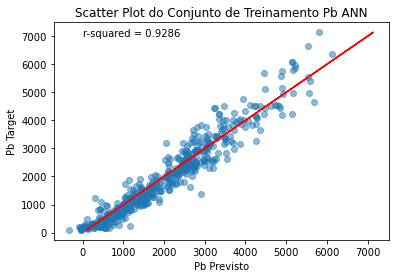

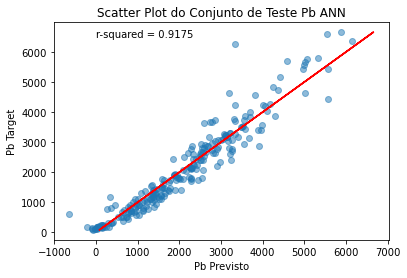

In [35]:
R2_treinamento = round(r2_score(y_train, Treinamento),4)
R2_test = round(r2_score(y_test, Resultado),4)

print(f' R2_Train = {R2_treinamento}')
print(f' R2_test = {R2_test}')    

plt.scatter(Treinamento, y_train, alpha=0.5)
plt.plot(y_train, y_train, color = 'red')
plt.title('Scatter Plot do Conjunto de Treinamento Pb ANN')
plt.ylabel('Pb Target')
plt.xlabel('Pb Previsto')
plt.annotate(f'r-squared = {R2_treinamento}', (0,7000))
plt.show()

plt.scatter(Resultado, y_test, alpha=0.5)
plt.plot(y_test,y_test, color = 'red')
plt.title('Scatter Plot do Conjunto de Teste Pb ANN')
plt.ylabel('Pb Target')
plt.xlabel('Pb Previsto')
plt.annotate(f'r-squared = {R2_test}', (0,6500))
plt.show()

# RESULTADOS

In [36]:
Error_Results_index = ['Standing', 'Vasquez-Beggs', 'Glaso', 'Al-Marhoun', 'Petroski-Farshad',
                       'Decision Tree', 'Random Forest', 'SVR', 'NN']
    
Error_Results.index = Error_Results_index
display(Error_Results)

MAE  MAPE_(%)    RMSE     SDa   SDr     Emax      R2
Standing          320.36     24.31  566.04  467.63  1.46  3549.07  0.8511
Vasquez-Beggs     373.12     28.19  655.57  540.16  1.45  4230.90  0.8002
Glaso             405.17     25.72  608.28  454.64  1.12  3580.01  0.8280
Al-Marhoun        426.71     21.68  734.84  599.50  1.40  4943.84  0.7490
Petroski-Farshad  559.36     78.19  734.31  476.73  0.85  4151.92  0.7494
Decision Tree     367.46     27.87  576.54  445.19  1.21  4130.56  0.8455
Random Forest     259.42     16.90  438.27  353.99  1.36  3868.68  0.9107
SVR               178.35     13.07  325.82  273.24  1.53  2727.40  0.9507
NN                283.05     23.12  421.34  312.75  1.10  2941.69  0.9175